<a href="https://colab.research.google.com/github/alice202122/AI_PROJECT/blob/main/Copia_di_AI_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CONNECTING TO DRIVE

In [121]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [122]:
%cd /gdrive/MyDrive/AI_Assignment/training_set

/gdrive/MyDrive/AI_Assignment/training_set


In [ ]:
!unzip training_set.zip

In [123]:
input_directory = '/gdrive/MyDrive/AI_Assignment/training_set'

# IMPORTING LIBRARIES

In [124]:
from scipy.io import loadmat

import numpy as np, os
from numpy import array, matrix, multiply, arange, absolute

from scipy import signal
from scipy import stats
from scipy.signal import lfilter, medfilt, resample, kaiserord, firwin, freqz, correlate

import pandas as pd

import ntpath

import matplotlib.pyplot as plt
from matplotlib import pylab as plt
 
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show, legend, axis

import copy

!pip install pyhrv
import pyhrv
import pyhrv.time_domain as td

!pip install biosppy
import biosppy
from biosppy.signals import ecg, tools

import math
from math import pi

import seaborn as sns

import re

from sklearn.preprocessing import StandardScaler  # standardize features by removing the mean and scaling to unit variance

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier

# Load NeuroKit and other useful packages
!pip install neurokit2
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5]  # Bigger images

#DATA LOADING

We want to adjust the dataset in a matrix to better organize the available data. The matrix structure is the following:

    | ECG (I & II lead) | R peaks location (samples) | Beats annotation ('N', 'S', 'V') |


In [125]:
def storage(empty_list, input_directory, last_character, name):
  for file in sorted(os.listdir(input_directory)):                  # search amongst files in input directory
    filename = ntpath.basename(file)                                # get file name
    filename = os.path.splitext(filename)[0]                        # remove file extension
    if filename.endswith(last_character):                           # check filename last character
      mat_file = filename + '.mat'                                  # rejoin extension to filename
      x = loadmat(mat_file)                                         # load file
      values = np.asarray(x[name])                                  # load values                                
      empty_list.append(values)                                     # store values in a list
  num_files = len(empty_list)                                       # checking all files have been stored

  return empty_list, num_files

###ECGs

In [126]:
ECGs = []         
ECGs, num_files = storage(ECGs, input_directory, ('8','0'), 'ecg')
print('Number of patients: ' +str(num_files))         # checking all files have been stored

Number of patients: 105


###R PEAKS LOCATION 

In [ ]:
Rpks = []          
Rpks, num_files = storage(Rpks, input_directory, 'k', 'rpeaks')
print('Number of patients: ' +str(num_files))        # checking all files have been stored

Number of patients: 105


###BEATS ANNOTATIONS

In [ ]:
anns = []         
anns, num_files = storage(anns, input_directory, 'n', 'labels')
print('Number of patients: ' +str(num_files))         # checking all files have been stored

Number of patients: 105


###FINAL MATRIX

In [ ]:
data = []                  

for patient in range(num_files):                                                  # scrolls patient by patient
  row = [ ECGs[patient], Rpks[patient], anns[patient] ]                        
  data.append(row)                                                                # store row in a list
data = pd.DataFrame(data)

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
data.to_pickle(path+'data')

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
data = pd.read_pickle(path+'data')

In [ ]:
data = data.values.tolist()

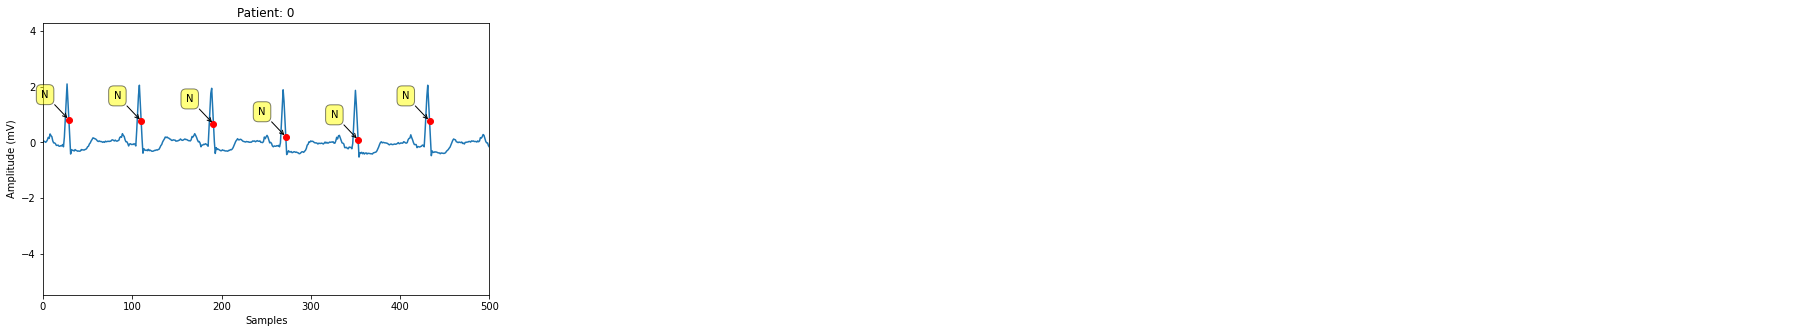

In [ ]:
patient = 0                                  

ECG = 0                                      # ECGs are stored in the first column of the data matrix
Ilead = 0                                    # I lead is stored in the first column of the ECGs
IIlead = 1                                   # II lead is stored in the first column of the ECGs
ECG_I = data[patient][ECG][:,Ilead]          # ECG I lead from patient S001_128
ECG_II = data[patient][ECG][:,IIlead]        # ECG II lead from patient S001_128
Rpk = 1
ann = 2                                      # annotations are stored in the third column of the data matrix

plt.title("Patient: " + str(patient))
plt.plot(ECG_I, color='C0')
plt.plot(data[patient][Rpk], ECG_I[data[patient][Rpk]], color='r', marker='o', linestyle='None')
plt.xlabel("Samples")
plt.xlim(0, 500)
plt.ylabel("Amplitude (mV)")

labels = ['{}'.format(i) for i in data[patient][ann]]
for label, x, y in zip(labels, data[patient][Rpk][:25], ECG_I[data[patient][Rpk][:25]]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

#DATA INSPECTION

###LABEL DISTRIBUTION

Text(0.5, 1.0, 'Classes Occurrences')

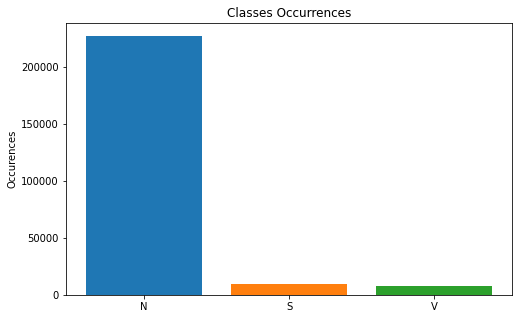

In [ ]:
N = []            # list initialization
S = []            # list initialization
V = []            # list initialization
ann = 2           # anns are stored in the third column of the data matrix

for patient in range(num_files):      # scrolls patient by patient
  for i in data[patient][ann]:          
    if i == 'N':                      
      N.append('N')                   # store N beats in a list
    elif i == 'S':                    
      S.append('S')                   # store S beats in a list
    elif i == 'V': 
      V.append('V')                   # store V beats in a list

plt.bar('N', len(N))
plt.bar('S', len(S))
plt.bar('V', len(V))
plt.ylabel('Occurences')
plt.title('Classes Occurrences')

The dataset is not balanced in terms of labels. An unbalanced dataset may lead to a biased machine learning (ML) model.

###SIGNALS LENGTH DISTRIBUTION

In [ ]:
ECGs_128 = []
ECGs_128, ECGs128_numfiles = storage(ECGs_128, input_directory, '8', 'ecg')
print('Number of patients (128 Hz): ' +str(ECGs128_numfiles))

Number of patients (128 Hz): 65


In [ ]:
ECGs_250 = []
ECGs_250, ECGs250_numfiles = storage(ECGs_250, input_directory, '0', 'ecg')
print('Number of patients (250 Hz): ' +str(ECGs250_numfiles))

Number of patients (250 Hz): 40


Text(0.5, 1.0, 'Signals length distribution')

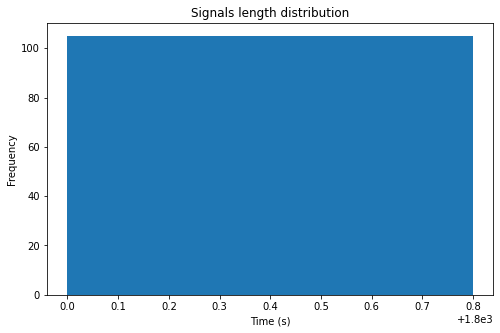

In [ ]:
ECGsfs_lengths = []
for i in ECGs_128:                    # scrolls patient by patient
  ECGsfs_lengths.append(len(i)/128)   # store signals duration in a list
for i in ECGs_250:                    # scrolls patient by patient
  ECGsfs_lengths.append(len(i)/250)   # store signals duration in a list

plt.bar(ECGsfs_lengths, len(ECGsfs_lengths), align='edge')
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.title("Signals length distribution")

The dataset is balanced in terms of signals duration.

#PRE-PROCESSING

###UPSAMPLING

Upsampling is the process of inserting zero-valued samples between the original samples of a signal to increase the sampling rate. We want, indeed, to bring all the signals at the same sampling frequency of 250 Hz. Downsampling to the 128 Hz is not recommendable otherwise we would lose informations.

In [ ]:
def upsampling(ECG_old, fs_old, fs_up):
  deltafs_old = 1/fs_old                                                          # old sampling interval (s)
  duration_old = int(deltafs_old*len(ECG_old))                                    # signal duration (s)
  samples_old = duration_old*fs_old                                               # number of samples with old sampling frequency
  timevec_old = np.linspace(0, duration_old, samples_old, False)                  # old time vector

  deltafs_up = 1/fs_up                                                            # new sampling interval (s)
  samples_up = duration_old*fs_up                                                 # number of samples expected with new sampling frequency
  timevec_up = np.linspace(0, duration_old, samples_up, False)                    # new time vector

  ECG_up = signal.resample(ECG_old, samples_up)                                   # ECG upsampled

  return timevec_old, timevec_up, ECG_up

####Example for one signal

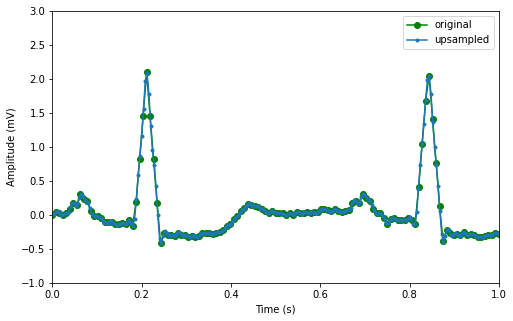

In [ ]:
patient = 0                                  

ECG = 0                                      # ECGs are stored in the first column of the data matrix
Ilead = 0                                    # I lead is stored in the first column of the ECGs
IIlead = 1                                   # II lead is stored in the first column of the ECGs
ECGI_128 = data[patient][ECG][:,Ilead]       
ECGII_128 = data[patient][ECG][:,IIlead]     

time_128, time_250, ECGI128_up = upsampling(ECGI_128, 128, 250)

plt.plot(time_128, ECGI_128, 'go-', time_250, ECGI128_up, '.-')
plt.axis([0, 1, -1, 3])                                         
plt.legend(['original', 'upsampled'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.show()

####For all 128 Hz signals

In [ ]:
ECGs128_up = []                                      

ECG = 0                                      # ECGs are stored in the first column of the data matrix
Ilead = 0                                    # I lead is stored in the first column of the ECGs
IIlead = 1                                   # II lead is stored in the first column of the ECGs

for patient in range(ECGs128_numfiles):              # scrolls patient by patient  
  ECGI_128 = data[patient][ECG][:,Ilead]                    
  ECGI128_up = upsampling(ECGI_128, 128, 250)[2]     # ECG upsampled    
  ECGII_128 = data[patient][ECG][:,IIlead]                
  ECGII128_up = upsampling(ECGII_128, 128, 250)[2]   # ECG upsampled
  ECG128_up = [ ECGI128_up, ECGII128_up]
  ECGs128_up.append(ECG128_up)                       # store ECGs upsampled in a list

In [ ]:
Rpks128_up = []                                      # list initialization

for patient in range(ECGs128_numfiles):              # scrolls patient by patient
  Rpk128_up = np.round((Rpks[patient]/128)*250)      # Rpks locations correspondance with the new sampling frequency
  Rpks128_up.append(Rpk128_up)                       # store new Rpks locations in a list

In [ ]:
ECGs250_up = []                                      # list initialization

ECG = 0                                              # ECGs are stored in the first column of the data matrix
Ilead = 0                                            # I lead is stored in the first column of the ECGs
IIlead = 1                                           # II lead is stored in the second column of the ECGs

for patient in range(ECGs128_numfiles,num_files):    # scrolls patient by patient  
  ECGI_250 = data[patient][ECG][:,Ilead]                    
  ECGI250_up = upsampling(ECGI_250, 250, 250)[2]     # ECG upsampled    
  ECGII_250 = data[patient][ECG][:,IIlead]                
  ECGII250_up = upsampling(ECGII_250, 250, 250)[2]   # ECG upsampled
  ECG250_up = [ ECGI250_up, ECGII250_up]
  ECGs250_up.append(ECG250_up)                       # store ECGs upsampled in a list

In [ ]:
Rpks250_up = []                                      # list initialization

for patient in range(ECGs128_numfiles,num_files):    # scrolls patient by patient
  Rpk250_up = np.round((Rpks[patient]/250)*250)      # Rpks locations correspondance with the new sampling frequency
  Rpks250_up.append(Rpk250_up)                       # store new Rpks locations in a list

In [ ]:
ECGs_up = ECGs128_up                        # new array of upsampled ECGs

for patient in range(ECGs250_numfiles):     # scroll patient by patient
  ECGs_up.append(ECGs250_up[patient])       # append the ECGs at 250 Hz
num_files = len(ECGs_up)                             
print('Number of patients: ' +str(num_files))                                  # checking all files have been stored        

Number of patients: 105


In [ ]:
Rpks_up = Rpks128_up                        # new array of upsampled Rpks

for patient in range(ECGs250_numfiles):     # scroll patient by patient
  Rpks_up.append(Rpks250_up[patient])       # append the Rpks at 250 Hz
num_files = len(Rpks_up)                             
print('Number of patients: ' +str(num_files))                                   # checking all files have been stored

Number of patients: 105


In [ ]:
data_up = []                                                                     # list initialization

for patient in range(num_files):                                                 # scrolls patient by patient
  row = [ ECGs_up[patient], Rpks_up[patient], anns[patient] ]                    # store ECG upsampled, R peaks location, beats annotation for each patient in a row
  data_up.append(row)                                                            # store row in a list
data_up = pd.DataFrame(data_up)

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
data_up.to_pickle(path+'data_up')

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
data_up = pd.read_pickle(path+'data_up')

In [ ]:
data_up = data_up.values.tolist()

In [127]:
fs = 250              # sampling frequency (Hz)
delta_fs = 1/fs       # sampling interval (s)

###BASELINE WANDER ESTIMATE

We want to detect the baseline and remove it from the overall signals because not necessary to the features of interest when computing the power spectrum. Indeed, the baseline wander mainly corresponds to the movement and respiration of the patient.

####Example for one signal

Text(0, 0.5, 'Amplitude (mV)')

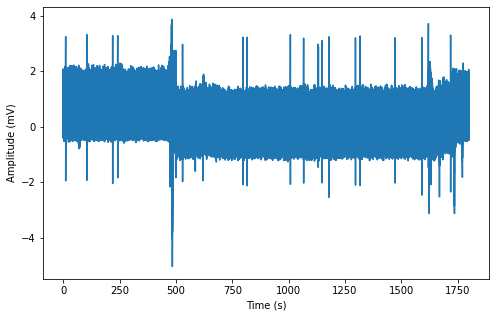

In [ ]:
patient = 0                                

ECG = 0                                      # ECGs are stored in the first column of the data matrix
Ilead = 0                                    # I lead is stored in the first column of the ECGs
IIlead = 1                                   # II lead is stored in the first column of the ECGs
ECGI_up = data_up[patient][ECG][Ilead]          # ECG I lead from patient S001_128
ECGII_up = data_up[patient][ECG][IIlead]        # ECG II lead from patient S001_128

duration = int(delta_fs*len(ECGI_up))                             # signal duration (s)
samples = duration*fs                                             # number of samples
time_vec = np.linspace(0, duration, samples, endpoint=False)      # time vector

plot(time_vec, ECGI_up)
xlabel('Time (s)')
ylabel('Amplitude (mV)')

In [ ]:
def power_spectrum(data, sampling_rate):
  fourier_transform = np.fft.rfft(data)                                 # FFT computation
  abs_fourier_transform = np.abs(fourier_transform)                     # FFT absolute value
  power_spectrum = np.square(abs_fourier_transform)                     # power spectrum
  frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))      # vector of frequencies

  return frequency, power_spectrum

Text(0, 0.5, 'Power Spectrum (dB/Hz)')

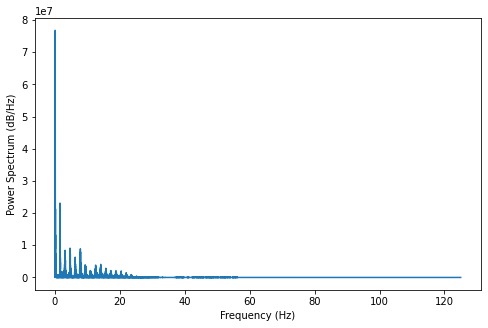

In [ ]:
ECGIup_f, ECGIup_ps = power_spectrum(ECGI_up, fs)
plt.plot(ECGIup_f, ECGIup_ps)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum (dB/Hz)')

Plotting the signal in the frequency domain we are able to detect the baseline contribution as the highest peak.
To detect the baseline wander we apply two median filters of different lengths. The foremost idea of the median filter is to track through the signal entry by entry, switching each entry with the median of neighboring entries. The pattern of neighbors is called the "window", which slides, entry by entry, over the entire signal.

######Median Filter (200 ms)

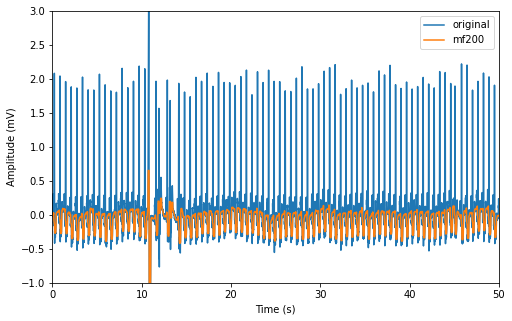

In [ ]:
kernel_t = 0.2                                                 # kernel duration (s)
kernel_smp = kernel_t*fs                                       # kernel length (samples)       
ECGIup_mf200 = signal.medfilt(ECGI_up, int(kernel_smp)+1)      # +1 the one being filtered
plt.plot(time_vec, ECGI_up, time_vec, ECGIup_mf200)
plt.axis([0, 50, -1, 3])
plt.legend(['original', 'mf200'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.show()

######Median Filter (600 ms)

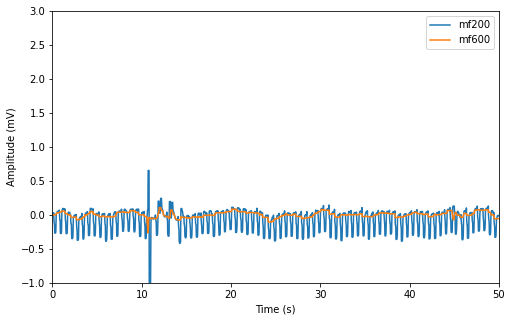

In [ ]:
kernel_t = 0.6                                                      # kernel duration (s)
kernel_smp = kernel_t*fs                                            # kernel length (samples)
ECGIup_mf600 = signal.medfilt(ECGIup_mf200, int(kernel_smp)+1)      # +1 the one being filtered
plt.plot(time_vec, ECGIup_mf200, time_vec, ECGIup_mf600)
plt.axis([0, 50, -1, 3])
plt.legend(['mf200', 'mf600'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.show()

######Baseline Removal

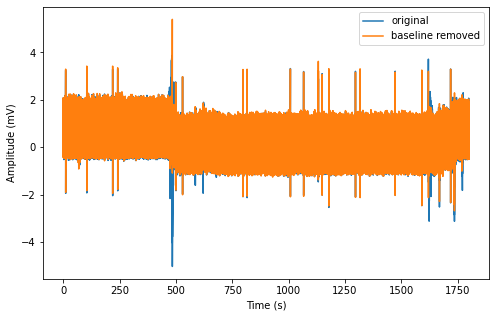

In [ ]:
ECGIup_blr = ECGI_up-ECGIup_mf600
plt.plot(time_vec, ECGI_up, time_vec, ECGIup_blr)
plt.legend(['original', 'baseline removed'], loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.show()

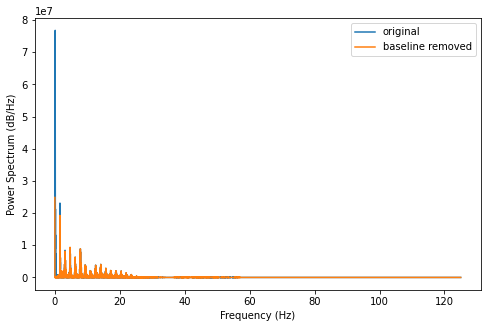

In [ ]:
ECGIupblr_f, ECGIupblr_ps = power_spectrum(ECGIup_blr, fs)
plt.plot(ECGIup_f, ECGIup_ps, ECGIupblr_f, ECGIupblr_ps)
plt.legend(['original', 'baseline removed'], loc='best')
plt.xlabel('Frequency (Hz)')

plt.ylabel('Power Spectrum (dB/Hz)')
plt.show()

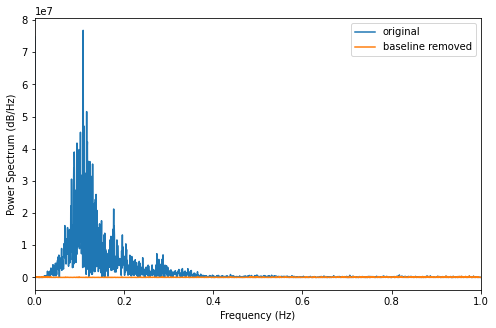

In [ ]:
plt.plot(ECGIup_f, ECGIup_ps, ECGIupblr_f, ECGIupblr_ps)
plt.legend(['original', 'baseline removed'], loc='best')
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 1)

plt.ylabel('Power Spectrum (dB/Hz)')
plt.show()

As we can see the baseline component has been removed. Moreover, the baseline wander removal could have been addressed also following a frequency-based approach so by applying a high pass filter with cutoff at 0.5 Hz.

####For all signals

In [ ]:
ECGsup_blr = []              
                         
ECG = 0                                               # ECGs are stored in the first column of the data matrix
Ilead = 0                                             # I lead is stored in the first column of the ECGs
IIlead = 1                                            # II lead is stored in the second column of the ECGs

for patient in range(num_files):                      # scrolls patient by patient
  ECGI_up = data_up[patient][ECG][Ilead]
  kernel_t = 0.2                                                    # kernel duration (s)
  kernel_smp = kernel_t*fs                                          # kernel length (samples)          
  ECGIup_mf200 = signal.medfilt(ECGI_up, int(kernel_smp)+1)         # +1 the one being filtered
  kernel_t = 0.6                                                    # kernel duration (s)
  kernel_smp = kernel_t*fs                                          # kernel length (samples)
  ECGIup_mf600 = signal.medfilt(ECGIup_mf200, int(kernel_smp)+1)    # +1 the one being filtered
  ECGIup_blr = ECGI_up-ECGIup_mf600                                 # baseline removal
  ECGII_up = data_up[patient][ECG][IIlead]  
  kernel_t = 0.2                                                       # kernel duration (s)
  kernel_smp = kernel_t*fs                                             # kernel length (samples)        
  ECGIIup_mf200 = signal.medfilt(ECGII_up, int(kernel_smp)+1)          # +1 the one being filtered
  kernel_t = 0.6                                                       # kernel duration (s)
  kernel_smp = kernel_t*fs                                             # kernel length (samples)
  ECGIIup_mf600 = signal.medfilt(ECGIIup_mf200, int(kernel_smp)+1)     # +1 the one being filtered
  ECGIIup_blr = ECGII_up-ECGIIup_mf600                                 # baseline removal
  ECGup_blr = [ ECGIup_blr, ECGIIup_blr ]
  ECGsup_blr.append(ECGup_blr)

In [ ]:
dataup_blr = []                                                                  # list initialization
for patient in range(num_files):                                                 # scrolls patient by patient
  row = [ ECGsup_blr[patient], Rpks_up[patient], anns[patient] ]                 # store ECG baseline removed, R peaks location, beats annotation for each patient in a row
  dataup_blr.append(row)                                                         # store row in a list
dataup_blr = pd.DataFrame(dataup_blr)

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
dataup_blr.to_pickle(path+'dataup_blr')

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
dataup_blr = pd.read_pickle(path+'dataup_blr')

In [ ]:
dataup_blr = dataup_blr.values.tolist()

###FILTERING

####Example for one signal

Text(0, 0.5, 'Amplitude (mV)')

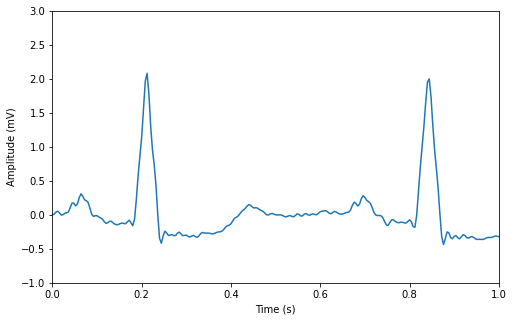

In [ ]:
patient = 0                                        # patient S001_128 (S001_250)
ECG = 0                                            # ECGs are stored in the first column of the data matrix
Ilead = 0                                          # I lead is stored in the first column of the ECGs
ECGIup_blr = dataup_blr[patient][ECG][Ilead]       # ECG I lead from patient S001_128 (S001_250)

duration = int(delta_fs*len(ECGIup_blr))                          # signal duration (s)
samples = duration*fs                                             # number of samples
time_vec = np.linspace(0, duration, samples, endpoint=False)      # time vector

plot(time_vec, ECGIup_blr)
plt.axis([0, 1, -1, 3])
xlabel('Time (s)')
ylabel('Amplitude (mV)')

From this plot it can be noticed the ECG signal needs to be smoothed out.

#####FIR filter

We apply a low pass filter with 35 Hz cutoff to get rid of the high frequencies responsible of signal ripples.

In [ ]:
def FIRlowpass(sample_rate, signal, time_axis, cutoff_hz, start, end, figs):

  global delay

  nyq_rate = sample_rate/2.0    # Nyquist frequency
  width = 5.0/nyq_rate          # the desired width of the transition from pass to stop,
                                # relative to the Nyquist rate.  We'll design the filter
                                # with a 5 Hz transition width.
  ripple_db = 60.0              # the desired attenuation in the stop band, in dB
  N, beta = kaiserord(ripple_db, width) # compute the order and Kaiser parameter for the FIR filter.
  taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
  filtered = lfilter(taps, 1.0, signal)

  if figs == True:
    
    figure(1) # filter coefficients
    plot(taps, 'bo-', linewidth=2)
    title('Filter Coefficients (%d taps)' % N)
    grid(True)

    figure(2) # filter magnitude response
    clf()
    w, h = freqz(taps, worN=8000)
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlabel('Frequency (Hz)')
    ylabel('Gain')
    title('Frequency Response')
    ylim(-0.05, 1.05)
    grid(True)
    ax1 = axes([0.42, 0.6, .45, .25])  # upper inset plot
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(0,8.0)
    ylim(0.9985, 1.001)
    grid(True)
    ax2 = axes([0.42, 0.25, .45, .25]) # lower inset plot
    plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
    xlim(60.0, 80.0)
    ylim(-0.05, 0.05)
    grid(True)

    delay = 0.5 * (N-1) / sample_rate   # the phase delay of the filtered signal
    figure(3)                           # original vs filtered signal
    axis([start, end, -1, 3])
    plot(time_axis, signal)
    #plot(time_axis-delay, filtered_x, 'r-')
    plot(time_axis[N-1:]-delay, filtered[N-1:], 'r', linewidth=1) # plot just the "good" part of the filtered signal. The first N-1
                                                                  # samples are "corrupted" by the initial conditions.
    legend(['original', 'filtered'], loc='best')
    xlabel('Time (s)')
    ylabel('Amplitude (mV)')
    grid(True)

    figure(4)
    signal_f, signal_ps = power_spectrum(signal, fs)
    filt_f, filt_ps = power_spectrum(filtered, fs)
    plot(signal_f, signal_ps, filt_f, filt_ps)
    legend(['original', 'filtered'], loc='best')
    xlabel('Frequency (Hz)')
    ylabel('Power Spectrum (dB/Hz)')

    show()
    
  elif figs == False:
    plt.close('all')

  return filtered, delay

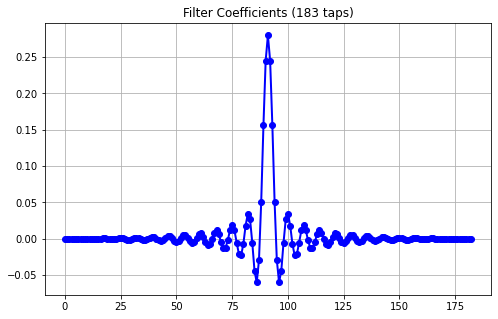

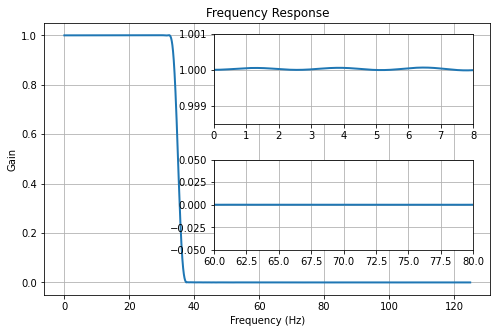

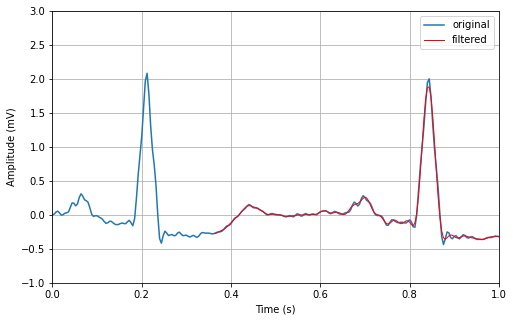

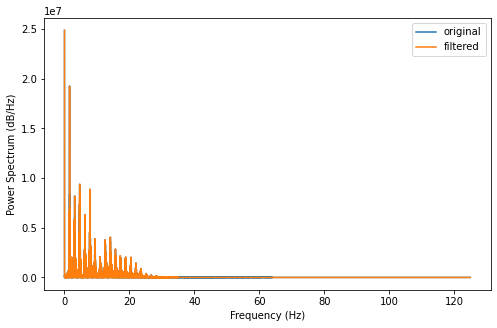

Delay (s): 0.364


In [ ]:
ECGIupblr_filt, delay = FIRlowpass(fs, ECGIup_blr, time_vec, 35, 0, 1, True)
print('Delay (s): ' +str(delay))

####For all signals

In [ ]:
ECGsupblr_filt = []    # list initialization
ECG = 0                # ECGs are stored in the first column of the data matrix
Ilead = 0              # I lead is stored in the first column of the ECGs
IIlead = 1             # II lead is stored in the second column of the ECGs
for patient in range(num_files):                   # scrolls patient by patient
  ECGIup_blr = dataup_blr[patient][ECG][Ilead]            
  ECGIupblr_filt = FIRlowpass(fs, ECGIup_blr, time_vec, 35, [], [], False)[0]         
  ECGIIup_blr = dataup_blr[patient][ECG][IIlead]            
  ECGIIupblr_filt = FIRlowpass(fs, ECGIIup_blr, time_vec, 35, [], [], False)[0]
  ECGupblr_filt = [ ECGIupblr_filt[int(delay*fs):], ECGIIupblr_filt[int(delay*fs):] ]
  ECGsupblr_filt.append(ECGupblr_filt)

In [ ]:
dataupblr_filt = []                                                              # list initialization
for patient in range(num_files):                                                 # scrolls patient by patient                                              
  row = [ ECGsupblr_filt[patient], Rpks_up[patient][:-1], anns[patient][:-1] ]  # store ECG filtered, R peaks location, beats annotation for each patient in a row
  dataupblr_filt.append(row)                                                   # store row in a list
dataupblr_filt = pd.DataFrame(dataupblr_filt)

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
dataupblr_filt.to_pickle(path+'dataupblr_filt')

In [128]:
path = '/gdrive/MyDrive/AI_Assignment/'
dataupblr_filt = pd.read_pickle(path+'dataupblr_filt')

In [129]:
dataupblr_filt = dataupblr_filt.values.tolist()

#FEATURE EXTRACTION

We are choosing and determining which are the characteristics of the beats that will be influencing our ML model. 

###BEATS EXTRACTION

Beats are extracted using a fixed window. However, it should be noted that as no ECG delineation is performed, the reported segments may not precisely account for these ECG regions (i.e., it is not an exact selection of the onset and offset of the ECG segment, but rather an approximate estimation). Nevertheless, the scope of this selection is to account for their intra-patient variability not to extract any precise parameter which could describe any of the ECG regions described above. Therefore, given that for the same patient the same ECG portion would be extracted for each of the mentioned segments, any variability produced by a premature atrial or ventricular beat, should be detected even if the ECG region is not accurately delineated.

In [666]:
wnwst_t = 0.35     # start of the window in s
wnwend_t = 0.35    # end of the window in s

In [667]:
def extractor(wnwst_t, wnwend_t, numfiles):
  wnwst_smp = round(wnwst_t*fs)           # number of samples before the R peak
  wnwend_smp = round(wnwend_t*fs)         # number of samples after the R peak
  rows = []                               # list initialization
  ECG_wnw = []                            # list initialization
  ECG = 0                                 # ECGs are stored in the first column of the data matrix
  Ilead = 0                               # I lead is stored in the first column of the ECGs
  IIlead = 1                              # II lead is stored in the second column of the ECGs
  Rpks = 1                                # Rpks are stored in the second column of the data matrix
  anns = 2                                # anns are stored in the third column of the data matrix

  for patient in range(num_files):
    print(patient)
    rows = []
    ECGIupblr_filt = dataupblr_filt[patient][ECG][Ilead]
    rpeaks = np.hstack(dataupblr_filt[patient][Rpks])
    rpeaks = rpeaks.astype(int)
    _, waves_dwtI = nk.ecg_delineate(ECGIupblr_filt, rpeaks, sampling_rate=250, method="dwt", show=False, show_type='all')
    ECGIIupblr_filt = dataupblr_filt[patient][ECG][IIlead]
    rpeaks = np.hstack(dataupblr_filt[patient][Rpks])
    rpeaks = rpeaks.astype(int)
    _, waves_dwtII = nk.ecg_delineate(ECGIIupblr_filt, rpeaks, sampling_rate=250, method="dwt", show=False, show_type='all')
    for n_beat, i in enumerate(rpeaks):
      ann = dataupblr_filt[patient][anns][n_beat]
      if (i-wnwst_smp)>0 and (i+wnwend_smp)<rpeaks[-1]:
        R = rpeaks[n_beat]
        R_t = R*delta_fs
        time = np.linspace((R_t-wnwst_t), (R_t+wnwend_t), wnwst_smp+wnwend_smp, endpoint=True)       
        PonI = waves_dwtI['ECG_P_Onsets'][n_beat]
        PonI = np.nan_to_num(PonI, nan=int(rpeaks[n_beat]-0.2*fs))
        PonI = PonI.astype(int)
        PpkI = waves_dwtI['ECG_P_Peaks'][n_beat]
        PpkI = np.nan_to_num(PpkI, nan=int(rpeaks[n_beat]-0.162*fs))
        PpkI = PpkI.astype(int)
        PoffI = waves_dwtI['ECG_P_Offsets'][n_beat]
        PoffI = np.nan_to_num(PoffI, nan=int(rpeaks[n_beat]-0.125*fs))
        PoffI = PoffI.astype(int)
        QI = waves_dwtI['ECG_Q_Peaks'][n_beat]
        QI = np.nan_to_num(QI, nan=int(rpeaks[n_beat]-0.05*fs))
        QI = QI.astype(int)
        RonI = waves_dwtI['ECG_R_Onsets'][n_beat]
        RonI = np.nan_to_num(RonI, nan=int(rpeaks[n_beat]-0.02*fs))
        RonI = RonI.astype(int)
        RoffI = waves_dwtI['ECG_R_Offsets'][n_beat]
        RoffI = np.nan_to_num(RoffI, nan=int(rpeaks[n_beat]+0.02*fs))
        RoffI = RoffI.astype(int)
        SI = waves_dwtI['ECG_S_Peaks'][n_beat]
        SI = np.nan_to_num(SI, nan=int(rpeaks[n_beat]+0.05*fs))
        SI = SI.astype(int)
        TonI = waves_dwtI['ECG_T_Onsets'][n_beat]
        TonI = np.nan_to_num(TonI, nan=int(rpeaks[n_beat]+0.105*fs))
        TonI = TonI.astype(int)
        TpkI = waves_dwtI['ECG_T_Peaks'][n_beat]
        TpkI = np.nan_to_num(TpkI, nan=int(rpeaks[n_beat]+0.195*fs))
        TpkI = TpkI.astype(int)
        ToffI = waves_dwtI['ECG_T_Offsets'][n_beat]
        ToffI = np.nan_to_num(ToffI, nan=int(rpeaks[n_beat]+0.305*fs))
        ToffI = ToffI.astype(int)
        PonII = waves_dwtII['ECG_P_Onsets'][n_beat]
        PonII = np.nan_to_num(PonII, nan=int(rpeaks[n_beat]-0.2*fs))
        PonII = PonII.astype(int)
        PpkII = waves_dwtII['ECG_P_Peaks'][n_beat]
        PpkII = np.nan_to_num(PpkII, nan=int(rpeaks[n_beat]-0.162*fs))
        PpkII = PpkII.astype(int)
        PoffII = waves_dwtII['ECG_P_Offsets'][n_beat]
        PoffII = np.nan_to_num(PoffII, nan=int(rpeaks[n_beat]-0.125*fs))
        PoffII = PoffII.astype(int)
        QII = waves_dwtII['ECG_Q_Peaks'][n_beat]
        QII = np.nan_to_num(QII, nan=int(rpeaks[n_beat]-0.05*fs))
        QII = QII.astype(int)
        RonII = waves_dwtII['ECG_R_Onsets'][n_beat]
        RonII = np.nan_to_num(RonII, nan=int(rpeaks[n_beat]-0.02*fs))
        RonII = RonII.astype(int)
        RoffII = waves_dwtII['ECG_R_Offsets'][n_beat]
        RoffII = np.nan_to_num(RoffII, nan=int(rpeaks[n_beat]+0.02*fs))
        RoffII = RoffII.astype(int)
        SII = waves_dwtII['ECG_S_Peaks'][n_beat]
        SII = np.nan_to_num(SII, nan=int(rpeaks[n_beat]+0.05*fs))
        SII = SII.astype(int)
        TonII = waves_dwtII['ECG_T_Onsets'][n_beat]
        TonII = np.nan_to_num(TonII, nan=int(rpeaks[n_beat]+0.105*fs))
        TonII = TonII.astype(int)
        TpkII = waves_dwtII['ECG_T_Peaks'][n_beat]
        TpkII = np.nan_to_num(TpkII, nan=int(rpeaks[n_beat]+0.195*fs))
        TpkII = TpkII.astype(int)
        ToffII = waves_dwtII['ECG_T_Offsets'][n_beat]
        ToffII = np.nan_to_num(ToffII, nan=int(rpeaks[n_beat]+0.305*fs))
        ToffII = ToffII.astype(int)
        row = [ i, ann, time, 
               ECGIupblr_filt[i-wnwst_smp:i+wnwend_smp], 
               [ PonI, PpkI, PoffI, QI, RonI, R, RoffI, SI, TonI, TpkI, ToffI ],
               [ ECGIupblr_filt[PonI], ECGIupblr_filt[PpkI], ECGIupblr_filt[PoffI], ECGIupblr_filt[QI], ECGIupblr_filt[RonI], ECGIupblr_filt[R], ECGIupblr_filt[RoffI], ECGIupblr_filt[SI], ECGIupblr_filt[TonI], ECGIupblr_filt[TpkI], ECGIupblr_filt[ToffI] ],
               ECGIIupblr_filt[i-wnwst_smp:i+wnwend_smp],
               [ PonII, PpkII, PoffII, QII, RonII, R, RoffII, SII, TonII, TpkII, ToffII ],
               [ ECGIIupblr_filt[PonII], ECGIIupblr_filt[PpkII], ECGIIupblr_filt[PoffII], ECGIIupblr_filt[QII], ECGIIupblr_filt[RonII], ECGIIupblr_filt[R], ECGIIupblr_filt[RoffII], ECGIIupblr_filt[SII], ECGIIupblr_filt[TonII], ECGIIupblr_filt[TpkII], ECGIIupblr_filt[ToffII] ] ]
        rows.append(row)
    lst = copy.deepcopy(rows)
    perpatient = [ patient, lst ]
    ECG_wnw.append(perpatient)

  return ECG_wnw

In [668]:
tot_beats1 = extractor(wnwst_t, wnwend_t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [657]:
tot_beats1 = pd.DataFrame(tot_beats1)

In [661]:
path = '/gdrive/MyDrive/AI_Assignment/'
tot_beats1.to_pickle(path+'tot_beats1')

In [662]:
path = '/gdrive/MyDrive/AI_Assignment/'
tot_beats1 = pd.read_pickle(path+'tot_beats1')

In [ ]:
tot_beats2 = extractor(wnwst_t, wnwend_t, [30,60])

In [ ]:
tot_beats2 = pd.DataFrame(tot_beats2)

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
tot_beats2.to_pickle(path+'tot_beats2')

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
tot_beats2 = pd.read_pickle(path+'tot_beats2')

In [ ]:
tot_beats3 = extractor(wnwst_t, wnwend_t, [60,90])

In [ ]:
tot_beats3 = pd.DataFrame(tot_beats3)

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
tot_beats3.to_pickle(path+'tot_beats3')

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
tot_beats3 = pd.read_pickle(path+'tot_beats3')

In [ ]:
tot_beats4 = extractor(wnwst_t, wnwend_t, [90,105])

In [ ]:
tot_beats4 = pd.DataFrame(tot_beats4)

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
tot_beats4.to_pickle(path+'tot_beats4')

In [ ]:
path = '/gdrive/MyDrive/AI_Assignment/'
tot_beats4 = pd.read_pickle(path+'tot_beats4')

In [ ]:
tot_beats = pd.concat([tot_beats1, tot_beats2, tot_beats3, tot_beats4], axis=0)

In [135]:
tot_beats = tot_beats.values.tolist()

####Example for one beat

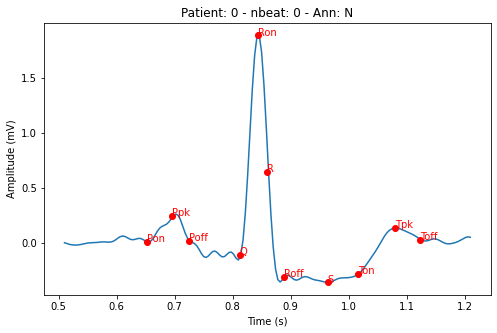

In [136]:
patient = 0       # patient S001_128 (S001_250)
n_beat = 0        # beats are stored by rows 
column = 1 
ann = 1
time = 2
ECG_lead = 3
if ECG_lead == 3:
  k = 0
elif ECG_lead == 6:
  k = 3
pts = 4+k
ECGlead_pts = 5+k

a = tot_beats[patient][column][n_beat][time]
b = tot_beats[patient][column][n_beat][ECG_lead]
c = tot_beats[patient][column][n_beat][pts]
c = [i*delta_fs for i in c]
d = tot_beats[patient][column][n_beat][ECGlead_pts]
labels = ['Pon', 'Ppk', 'Poff', 'Q', 'Ron', 'R', 'Roff', 'S', 'Ton', 'Tpk', 'Toff']
for i, txt in enumerate(labels):
    plt.annotate(txt, (c[i], d[i]), color='r')
plt.plot(a,b) 
plt.plot(c, d, color='r', marker='o', linestyle='None')  
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Patient: ' +str(patient)+ ' - nbeat: ' +str(n_beat)+ ' - Ann: ' +str(tot_beats[patient][column][n_beat][1]))
show()

###HRV FEATURES

For each individual beat, a set of features was computed taking into account the neighboring beats.
A window of three minutes centered around the current beat is considered for the extraction of the heart rate variability (HRV) features.

In [222]:
tpltHRVst_t = 90
tpltHRVend_t = 90            
tpltHRVst_smp = tpltHRVst_t*fs      # number of samples in the window
tpltHRVend_smp = tpltHRVend_t*fs      # number of samples in the window

In [265]:
column = 1                  # Rpks, anns, time and ECGs are stored in the second column in tot_beats matrix
beat_rpk = 0                # beat R peak location is stored in the first column 

HRV = []                    # list initialization
tpltbeatsloc_time = []      # list initialization

for patient in range(1):
  for idxi, i in enumerate(tot_beats[patient][column]):
    if (i[beat_rpk]-tpltHRVst_smp)>0 and (i[beat_rpk]+tpltHRVend_smp)<tot_beats[patient][column][-1][beat_rpk]:
      tpltbeatsloc_time = []
      for idkk, k in enumerate(tot_beats[patient][column]):
        if k[beat_rpk]>(i[beat_rpk]-tpltHRVst_smp) and k[beat_rpk]<(i[beat_rpk]+tpltHRVend_smp):  # window centered around the beat
          k_t = k[beat_rpk]/fs          # beats location in time (s)
          tpltbeatsloc_time.append(k_t)
      tpltbeatsloc_time = np.vstack(tpltbeatsloc_time)
      lst = copy.deepcopy(tpltbeatsloc_time)
      RRs = [j-i for i, j in zip(np.array(lst[:-1]), np.array(lst[1:]))]               # series of the distance of two consecutive R peaks of each beat
      RRs = np.vstack(RRs)
      RRs_mean = np.mean(RRs)
      lst1 = copy.deepcopy(RRs_mean)
      RRs_median = np.median(RRs)
      lst2 = copy.deepcopy(RRs_median)
      RRs_var = np.var(RRs)
      lst3 = copy.deepcopy(RRs_var)
      RRs_skew = stats.skew(RRs)
      lst4 = copy.deepcopy(RRs_skew)
      RRs_std = np.std(RRs)
      lst5 = copy.deepcopy(RRs_std)
      RRs_kurt = stats.kurtosis(RRs)
      lst6 = copy.deepcopy(RRs_kurt)
      RMSSD = np.array(pyhrv.time_domain.rmssd(RRs, lst))                              # root mean square of successive differences
      lst7 = copy.deepcopy(RMSSD)
      dRRs = [j-i for i, j in zip(np.array(RRs[:-1]), np.array(RRs[1:]))]              # series of the difference of consecutive RRs, namely dRRn = RRn+1 − RRn
      dRRs = np.vstack(dRRs)
      dRRs_mean = np.mean(dRRs)
      lst8 = copy.deepcopy(dRRs_mean)
      dRRs_std = np.std(dRRs)
      lst9 = copy.deepcopy(dRRs_std)
      pNN10 = np.concatenate([i>0.01 for i in dRRs]).sum()*100/len(dRRs)                                # percentage of successive interval differences greater than 10
      lst10 = copy.deepcopy(pNN10)
      pNN20 = np.concatenate([i>0.02 for i in dRRs]).sum()*100/len(dRRs)                                # percentage of successive interval differences greater than 20
      lst11 = copy.deepcopy(pNN20)
      pNN30 = np.concatenate([i>0.03 for i in dRRs]).sum()*100/len(dRRs)                                # percentage of successive interval differences greater than 30
      lst12 = copy.deepcopy(pNN30)
      pNN40 = np.concatenate([i>0.04 for i in dRRs]).sum()*100/len(dRRs)                                # percentage of successive interval differences greater than 40
      lst13 = copy.deepcopy(pNN40)
      pNN50 = np.concatenate([i>0.05 for i in dRRs]).sum()*100/len(dRRs)                                # percentage of successive interval differences greater than 50
      lst14 = copy.deepcopy(pNN50)
      row = [ patient, i[0], lst, np.round(lst1,4), np.round(lst2,4), np.round(lst3,4), np.round(lst4,4), np.round(lst5,4), np.round(lst6,4), np.round(lst7,4), np.round(lst8,4), np.round(lst9,4), np.round(lst10,4), np.round(lst11,4), np.round(lst12,4), np.round(lst13,4), np.round(lst14,4), i[1] ]
      HRV.append(row)

HRV = pd.DataFrame(HRV, columns=['Patient', 'Beat Loc.', 'Template Beats Loc. in Time (s)', 'RRs mean', 'RRs median', 'RRs var', 'RRs skew', 'RRs std', 'RRs kurt', 'RMSSD', 'dRRs_mean', 'dRRs_std', 'pNN10', 'pNN20', 'pNN30', 'pNN40', 'pNN50', 'Beat Ann.' ])

In [266]:
path = '/gdrive/MyDrive/AI_Assignment/'
HRV.to_pickle(path+'HRV')

In [267]:
path = '/gdrive/MyDrive/AI_Assignment/'
HRV = pd.read_pickle(path+'HRV')
HRV

,Patient,Beat Loc.,Template Beats Loc. in Time (s),RRs mean,RRs median,RRs var,RRs skew,RRs std,RRs kurt,RMSSD,dRRs_mean,dRRs_std,pNN10,pNN20,pNN30,pNN40,pNN50,Beat Ann.
0,0,22557,"[[0.86], [1.492], [2.124], [2.756], [3.384], [...",0.6331,0.636,0.0029,[-0.0191],0.0543,[26.6506],[95.855],-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,N
1,0,22721,"[[1.492], [2.124], [2.756], [3.384], [4.016], ...",0.6324,0.636,0.0031,[-0.1074],0.0553,[24.8559],[95.8994],-0.0006,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,N
2,0,22885,"[[2.124], [2.756], [3.384], [4.016], [4.648], ...",0.6312,0.636,0.0033,[-0.2334],0.0571,[22.0172],[95.7318],-0.0006,0.0958,9.8940,4.5936,3.5336,2.1201,2.1201,N
3,0,23049,"[[2.756], [3.384], [4.016], [4.648], [5.28], [...",0.6305,0.636,0.0034,[-0.3039],0.0582,[20.5958],[95.7338],-0.0007,0.0958,9.8940,4.5936,3.5336,2.1201,2.1201,N
4,0,23215,"[[3.384], [4.016], [4.648], [5.28], [5.92], [6...",0.6293,0.636,0.0036,[-0.4059],0.0600,[18.3267],[95.5777],-0.0007,0.0957,10.2113,4.5775,3.5211,2.1127,2.1127,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,0,426453,"[[1615.936], [1616.58], [1617.22], [1617.868],...",0.6019,0.596,0.0051,[13.9479],0.0717,[220.0838],[103.3455],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,N
2551,0,426602,"[[1616.58], [1617.22], [1617.868], [1618.508],...",0.6017,0.596,0.0051,[13.9772],0.0717,[220.7067],[103.3454],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,N
2552,0,426750,"[[1617.22], [1617.868], [1618.508], [1619.148]...",0.6016,0.596,0.0051,[14.0024],0.0716,[221.2413],[103.345],-0.0002,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,N
2553,0,426898,"[[1617.868], [1618.508], [1619.148], [1619.58]...",0.6014,0.596,0.0051,[14.0363],0.0716,[221.969],[103.3452],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,N


###MORPHOLOGICAL FEATURES

The maximum of cross-correlation function between each detected beat and the following beat is calculated, as well as the maximum of cross-correlation between the current beat and the previous beat detected.
Another feature is the maximum of cross-correlation with respect to a normal beat template. This latter is computed for each patient as the averaged beat of a sequence of many normal sinus beats.

In [268]:
column = 1            # Rpks, anns, time and ECGs are stored in the second column in tot_beats matrix
beat_rpk = 0          # beat R peak location is stored in the first column
ECG_Ilead = 3          # ECG I lead is stored in the fourth column
ECG_IIlead = 6        # ECG II lead is stored in the fifth column 
Pon = 0
Poff = 2
Ton = 8
Toff = 10


CORR = []             # list initialization
tpltbeats_loc = []    # list initialization

sum = 0
count = 0

corr1 = []
corr2 = []

for patient in range(1):
  for idxi, i in enumerate(tot_beats[patient][column]):
    if( i[1] == 'N'):
      sum = sum + i[ECG_Ilead]
      count = count + 1
    mean = np.vstack(sum)/count 
    if (i[beat_rpk]-tpltHRVst_smp)>0 and (i[beat_rpk]+tpltHRVend_smp)<tot_beats[patient][column][-1][beat_rpk]:
      tpltbeats_loc = []
      corr1I = []
      corr2I = []
      corrxyI = []
      PdurI = []
      TdurI = []
      tplt = [ tot_beats[patient][column][idxi-1][beat_rpk], tot_beats[patient][column][idxi+1][beat_rpk] ]
      tpltbeats_loc.append(tplt)
      corr1_Ilead = (np.argmax(signal.correlate(tot_beats[patient][column][idxi][ECG_Ilead], tot_beats[patient][column][idxi-1][ECG_Ilead])) - len(tot_beats[patient][column][idxi-1][ECG_Ilead]))
      corr1I.append(corr1_Ilead)
      corr2_Ilead = (np.argmax(signal.correlate(tot_beats[patient][column][idxi][ECG_Ilead], tot_beats[patient][column][idxi+1][ECG_Ilead])) - len(tot_beats[patient][column][idxi+1][ECG_Ilead]))
      corr2I.append(corr2_Ilead)
      corrxy_Ilead = (np.argmax(signal.correlate(np.vstack(tot_beats[patient][column][idxi][ECG_Ilead]), mean)) - len(mean))
      corrxyI.append(corrxy_Ilead)
      Pdur_Ilead = tot_beats[patient][column][idxi][4][Poff]*delta_fs-tot_beats[patient][column][idxi][4][Pon]*delta_fs
      PdurI.append(Pdur_Ilead)
      Tdur_Ilead = tot_beats[patient][column][idxi][4][Toff]*delta_fs-tot_beats[patient][column][idxi][4][Ton]*delta_fs
      TdurI.append(Tdur_Ilead)
      tpltbeats_loc = np.vstack(tpltbeats_loc)
      lst = copy.deepcopy(tpltbeats_loc)
      corr1I = np.vstack(corr1I)
      lst1 = copy.deepcopy(corr1I)
      corr2I = np.vstack(corr2I)
      lst2 = copy.deepcopy(corr2I)
      corrxyI = np.vstack(corrxyI)
      lst3 = copy.deepcopy(corrxyI)
      PdurI = np.vstack(PdurI)
      lst4 = copy.deepcopy(PdurI)
      TdurI = np.vstack(TdurI)
      lst5 = copy.deepcopy(TdurI)
      corr1II = []
      corr2II = []
      corrxyII = []
      PdurII = []
      TdurII = []
      corr1_IIlead = (np.argmax(signal.correlate(tot_beats[patient][column][idxi][ECG_IIlead], tot_beats[patient][column][idxi-1][ECG_IIlead])) - len(tot_beats[patient][column][idxi-1][ECG_IIlead]))
      corr1II.append(corr1_IIlead)
      corr2_IIlead = (np.argmax(signal.correlate(tot_beats[patient][column][idxi][ECG_IIlead], tot_beats[patient][column][idxi+1][ECG_IIlead])) - len(tot_beats[patient][column][idxi+1][ECG_IIlead]))
      corr2II.append(corr2_IIlead)
      corrxy_IIlead = (np.argmax(signal.correlate(np.vstack(tot_beats[patient][column][idxi][ECG_IIlead]), mean)) - len(mean))
      corrxyII.append(corrxy_IIlead)
      Pdur_IIlead = tot_beats[patient][column][idxi][7][Poff]*delta_fs-tot_beats[patient][column][idxi][7][Pon]*delta_fs
      PdurII.append(Pdur_IIlead)
      Tdur_IIlead = tot_beats[patient][column][idxi][7][Toff]*delta_fs-tot_beats[patient][column][idxi][7][Ton]*delta_fs
      TdurII.append(Tdur_IIlead)
      corr1II = np.vstack(corr1II)
      lst6 = copy.deepcopy(corr1II)
      corr2II = np.vstack(corr2II)
      lst7 = copy.deepcopy(corr2II)
      corrxyII = np.vstack(corrxyII)
      lst8 = copy.deepcopy(corrxyII)
      PdurII = np.vstack(PdurII)
      lst9 = copy.deepcopy(PdurII)
      TdurII = np.vstack(TdurII)
      lst10 = copy.deepcopy(TdurII)
      row = [ patient, i[0], lst, lst1, lst2, lst3, np.round(lst4,4), np.round(lst5,4), np.round(lst6,4), np.round(lst7,4), np.round(lst8,4), np.round(lst9,4), np.round(lst10,4), i[1] ]
      CORR.append(row)

CORR = pd.DataFrame(CORR, columns=[ 'Patient', 'Beat Loc.', 'Template Beats Loc.', 'Corr1 Ilead', 'Corr2 Ilead', 'Corrxy Ilead', 'Pdur Ilead (s)','Tdur Ilead (s)', 'Corr1 IIlead', 'Corr2 IIlead', 'Corrxy IIlead', 'Pdur IIlead (s)','Tdur IIlead (s)', 'Beat Ann.' ])

In [269]:
path = '/gdrive/MyDrive/AI_Assignment/'
CORR.to_pickle(path+'CORR')

In [270]:
path = '/gdrive/MyDrive/AI_Assignment/'
CORR = pd.read_pickle(path+'CORR')
CORR

,Patient,Beat Loc.,Template Beats Loc.,Corr1 Ilead,Corr2 Ilead,Corrxy Ilead,Pdur Ilead (s),Tdur Ilead (s),Corr1 IIlead,Corr2 IIlead,Corrxy IIlead,Pdur IIlead (s),Tdur IIlead (s),Beat Ann.
0,0,22557,"[[22393, 22721]]",[[-2]],[[0]],[[-2]],[[0.064]],[[0.096]],[[-1]],[[0]],[[-4]],[[0.06]],[[0.032]],N
1,0,22721,"[[22557, 22885]]",[[-2]],[[-1]],[[-2]],[[0.072]],[[0.1]],[[-2]],[[-1]],[[-4]],[[0.064]],[[0.052]],N
2,0,22885,"[[22721, 23049]]",[[-1]],[[-2]],[[-2]],[[0.068]],[[0.072]],[[-1]],[[-2]],[[-4]],[[0.056]],[[0.076]],N
3,0,23049,"[[22885, 23215]]",[[0]],[[0]],[[-1]],[[0.064]],[[0.072]],[[0]],[[-1]],[[-3]],[[0.056]],[[0.04]],N
4,0,23215,"[[23049, 23379]]",[[-2]],[[-1]],[[-2]],[[0.068]],[[0.096]],[[-1]],[[-1]],[[-3]],[[0.064]],[[0.028]],N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,0,426453,"[[426305, 426602]]",[[0]],[[-1]],[[-1]],[[0.068]],[[0.1]],[[0]],[[-1]],[[-1]],[[0.056]],[[0.048]],N
2551,0,426602,"[[426453, 426750]]",[[-1]],[[-1]],[[-1]],[[0.072]],[[0.072]],[[-1]],[[-1]],[[-2]],[[0.064]],[[0.056]],N
2552,0,426750,"[[426602, 426898]]",[[-1]],[[-2]],[[-1]],[[0.068]],[[0.08]],[[-1]],[[-3]],[[-1]],[[0.06]],[[0.04]],N
2553,0,426898,"[[426750, 427051]]",[[0]],[[3]],[[1]],[[0.068]],[[0.08]],[[1]],[[3]],[[0]],[[0.06]],[[0.032]],N


######Example for two beats

Text(0.5, 1.0, 'Beat_1 at sample n.[22557] correlated with beat_2 at sample n.22721')

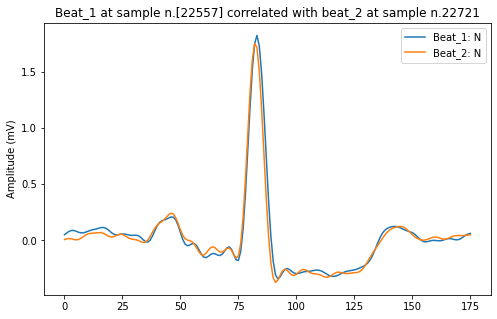

In [271]:
idxk = 0
n_beat = 1
          
patient = 0       # patient S001_128 (S001_250)
column = 1        # Rpks, anns, time and ECGs are stored in the second column in tot_beats matrix
beat_rpk = 0      # beat R peak location is stored in the first column
ann = 1
ECG_Ilead = 3     # ECG I =3, ECGII_lead =6

for idx, i in enumerate(tot_beats[patient][column]):
  if (i[beat_rpk] == CORR['Beat Loc.'][idxk]):
    beat1 = tot_beats[patient][column][idx][ECG_Ilead]
    time = np.arange(0, len(beat1), 1) 
    idx1 = idx

for idx, i in enumerate(tot_beats[patient][column]):
  if (i[beat_rpk] == CORR['Template Beats Loc.'][idxk][0][n_beat]):
    beat2 = tot_beats[patient][column][idx][ECG_Ilead]
    idx2 = idx

plt.plot(beat1, label = 'Beat_1: %s' %tot_beats[patient][column][idx1][ann])
if n_beat==0:
  plt.plot(time+CORR['Corr1 Ilead'][idxk][0], beat2, label = 'Beat_2: %s' %tot_beats[patient][column][idx2][ann])
elif n_beat==1:
  plt.plot(time+CORR['Corr2 Ilead'][idxk][0], beat2, label = 'Beat_2: %s' %tot_beats[patient][column][idx2][ann])
plt.legend()
plt.ylabel('Amplitude (mV)')
plt.title('Beat_1 at sample n.[' +str(tot_beats[patient][column][idx1][beat_rpk])+ '] correlated with beat_2 at sample n.' +str(tot_beats[patient][column][idx2][beat_rpk]) )

###TOTAL FEATURES

In [669]:
HRV_copy = HRV.copy(deep=True)
HRV_copy = HRV_copy.drop(columns=['Patient', 'Beat Loc.', 'Beat Ann.', 'Template Beats Loc. in Time (s)'], inplace=False)

In [670]:
CORR_copy = CORR.copy(deep=True)
CORR_copy = CORR_copy.drop(columns=['Patient', 'Beat Loc.', 'Template Beats Loc.' ], inplace=False)

In [671]:
features = pd.concat([HRV_copy, CORR_copy], axis=1)

In [672]:
path = '/gdrive/MyDrive/AI_Assignment/'
features.to_pickle(path+'features') 

In [673]:
path = '/gdrive/MyDrive/AI_Assignment/'
features = pd.read_pickle(path+'features')
features

,RRs mean,RRs median,RRs var,RRs skew,RRs std,RRs kurt,RMSSD,dRRs_mean,dRRs_std,pNN10,pNN20,pNN30,pNN40,pNN50,Corr1 Ilead,Corr2 Ilead,Corrxy Ilead,Pdur Ilead (s),Tdur Ilead (s),Corr1 IIlead,Corr2 IIlead,Corrxy IIlead,Pdur IIlead (s),Tdur IIlead (s),Beat Ann.
0,0.6331,0.636,0.0029,[-0.0191],0.0543,[26.6506],[95.855],-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,[[-2]],[[0]],[[-2]],[[0.064]],[[0.096]],[[-1]],[[0]],[[-4]],[[0.06]],[[0.032]],N
1,0.6324,0.636,0.0031,[-0.1074],0.0553,[24.8559],[95.8994],-0.0006,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,[[-2]],[[-1]],[[-2]],[[0.072]],[[0.1]],[[-2]],[[-1]],[[-4]],[[0.064]],[[0.052]],N
2,0.6312,0.636,0.0033,[-0.2334],0.0571,[22.0172],[95.7318],-0.0006,0.0958,9.8940,4.5936,3.5336,2.1201,2.1201,[[-1]],[[-2]],[[-2]],[[0.068]],[[0.072]],[[-1]],[[-2]],[[-4]],[[0.056]],[[0.076]],N
3,0.6305,0.636,0.0034,[-0.3039],0.0582,[20.5958],[95.7338],-0.0007,0.0958,9.8940,4.5936,3.5336,2.1201,2.1201,[[0]],[[0]],[[-1]],[[0.064]],[[0.072]],[[0]],[[-1]],[[-3]],[[0.056]],[[0.04]],N
4,0.6293,0.636,0.0036,[-0.4059],0.0600,[18.3267],[95.5777],-0.0007,0.0957,10.2113,4.5775,3.5211,2.1127,2.1127,[[-2]],[[-1]],[[-2]],[[0.068]],[[0.096]],[[-1]],[[-1]],[[-3]],[[0.064]],[[0.028]],N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,0.6019,0.596,0.0051,[13.9479],0.0717,[220.0838],[103.3455],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[0]],[[-1]],[[-1]],[[0.068]],[[0.1]],[[0]],[[-1]],[[-1]],[[0.056]],[[0.048]],N
2551,0.6017,0.596,0.0051,[13.9772],0.0717,[220.7067],[103.3454],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[-1]],[[-1]],[[-1]],[[0.072]],[[0.072]],[[-1]],[[-1]],[[-2]],[[0.064]],[[0.056]],N
2552,0.6016,0.596,0.0051,[14.0024],0.0716,[221.2413],[103.345],-0.0002,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[-1]],[[-2]],[[-1]],[[0.068]],[[0.08]],[[-1]],[[-3]],[[-1]],[[0.06]],[[0.04]],N
2553,0.6014,0.596,0.0051,[14.0363],0.0716,[221.969],[103.3452],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[0]],[[3]],[[1]],[[0.068]],[[0.08]],[[1]],[[3]],[[0]],[[0.06]],[[0.032]],N


###MISSING DATA HANDLING

In [676]:
# Compute the percentage of missing values for each feature 
percent_missing = features.isnull().sum() * 100 / len(features)

# Store them in a dataframe and display them
missing_value_df = pd.DataFrame({'column_name': features.columns,
                                 'percent_missing': percent_missing})
display(missing_value_df)

# Eliminate subjects with more than a certain number of missing features: for 
# instance 19.  
features = features.dropna(thresh=5)

,column_name,percent_missing
RRs mean,RRs mean,0.0
RRs median,RRs median,0.0
RRs var,RRs var,0.0
RRs skew,RRs skew,0.0
RRs std,RRs std,0.0
RRs kurt,RRs kurt,0.0
RMSSD,RMSSD,0.0
dRRs_mean,dRRs_mean,0.0
dRRs_std,dRRs_std,0.0
pNN10,pNN10,0.0


In [677]:
path = '/gdrive/MyDrive/AI_Assignment/'
features.to_csv(path+'features.csv')

#MODEL DEFINITION AND TRAINING

In [678]:
path = '/gdrive/MyDrive/AI_Assignment/'
features = pd.read_csv(path+'features.csv')
features

,Unnamed: 0,RRs mean,RRs median,RRs var,RRs skew,RRs std,RRs kurt,RMSSD,dRRs_mean,dRRs_std,pNN10,pNN20,pNN30,pNN40,pNN50,Corr1 Ilead,Corr2 Ilead,Corrxy Ilead,Pdur Ilead (s),Tdur Ilead (s),Corr1 IIlead,Corr2 IIlead,Corrxy IIlead,Pdur IIlead (s),Tdur IIlead (s),Beat Ann.
0,0,0.6331,0.636,0.0029,[-0.0191],0.0543,[26.6506],[95.855],-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,[[-2]],[[0]],[[-2]],[[0.064]],[[0.096]],[[-1]],[[0]],[[-4]],[[0.06]],[[0.032]],N
1,1,0.6324,0.636,0.0031,[-0.1074],0.0553,[24.8559],[95.8994],-0.0006,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,[[-2]],[[-1]],[[-2]],[[0.072]],[[0.1]],[[-2]],[[-1]],[[-4]],[[0.064]],[[0.052]],N
2,2,0.6312,0.636,0.0033,[-0.2334],0.0571,[22.0172],[95.7318],-0.0006,0.0958,9.8940,4.5936,3.5336,2.1201,2.1201,[[-1]],[[-2]],[[-2]],[[0.068]],[[0.072]],[[-1]],[[-2]],[[-4]],[[0.056]],[[0.076]],N
3,3,0.6305,0.636,0.0034,[-0.3039],0.0582,[20.5958],[95.7338],-0.0007,0.0958,9.8940,4.5936,3.5336,2.1201,2.1201,[[0]],[[0]],[[-1]],[[0.064]],[[0.072]],[[0]],[[-1]],[[-3]],[[0.056]],[[0.04]],N
4,4,0.6293,0.636,0.0036,[-0.4059],0.0600,[18.3267],[95.5777],-0.0007,0.0957,10.2113,4.5775,3.5211,2.1127,2.1127,[[-2]],[[-1]],[[-2]],[[0.068]],[[0.096]],[[-1]],[[-1]],[[-3]],[[0.064]],[[0.028]],N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,2550,0.6019,0.596,0.0051,[13.9479],0.0717,[220.0838],[103.3455],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[0]],[[-1]],[[-1]],[[0.068]],[[0.1]],[[0]],[[-1]],[[-1]],[[0.056]],[[0.048]],N
2551,2551,0.6017,0.596,0.0051,[13.9772],0.0717,[220.7067],[103.3454],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[-1]],[[-1]],[[-1]],[[0.072]],[[0.072]],[[-1]],[[-1]],[[-2]],[[0.064]],[[0.056]],N
2552,2552,0.6016,0.596,0.0051,[14.0024],0.0716,[221.2413],[103.345],-0.0002,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[-1]],[[-2]],[[-1]],[[0.068]],[[0.08]],[[-1]],[[-3]],[[-1]],[[0.06]],[[0.04]],N
2553,2553,0.6014,0.596,0.0051,[14.0363],0.0716,[221.969],[103.3452],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[0]],[[3]],[[1]],[[0.068]],[[0.08]],[[1]],[[3]],[[0]],[[0.06]],[[0.032]],N


In [681]:
features = features.drop(columns=['Unnamed: 0'])
features = features.rename(columns={'Beat Ann.':'Target'})
features

,RRs mean,RRs median,RRs var,RRs skew,RRs std,RRs kurt,RMSSD,dRRs_mean,dRRs_std,pNN10,pNN20,pNN30,pNN40,pNN50,Corr1 Ilead,Corr2 Ilead,Corrxy Ilead,Pdur Ilead (s),Tdur Ilead (s),Corr1 IIlead,Corr2 IIlead,Corrxy IIlead,Pdur IIlead (s),Tdur IIlead (s),Target
0,0.6331,0.636,0.0029,[-0.0191],0.0543,[26.6506],[95.855],-0.0005,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,[[-2]],[[0]],[[-2]],[[0.064]],[[0.096]],[[-1]],[[0]],[[-4]],[[0.06]],[[0.032]],N
1,0.6324,0.636,0.0031,[-0.1074],0.0553,[24.8559],[95.8994],-0.0006,0.0960,9.9291,4.6099,3.5461,2.1277,2.1277,[[-2]],[[-1]],[[-2]],[[0.072]],[[0.1]],[[-2]],[[-1]],[[-4]],[[0.064]],[[0.052]],N
2,0.6312,0.636,0.0033,[-0.2334],0.0571,[22.0172],[95.7318],-0.0006,0.0958,9.8940,4.5936,3.5336,2.1201,2.1201,[[-1]],[[-2]],[[-2]],[[0.068]],[[0.072]],[[-1]],[[-2]],[[-4]],[[0.056]],[[0.076]],N
3,0.6305,0.636,0.0034,[-0.3039],0.0582,[20.5958],[95.7338],-0.0007,0.0958,9.8940,4.5936,3.5336,2.1201,2.1201,[[0]],[[0]],[[-1]],[[0.064]],[[0.072]],[[0]],[[-1]],[[-3]],[[0.056]],[[0.04]],N
4,0.6293,0.636,0.0036,[-0.4059],0.0600,[18.3267],[95.5777],-0.0007,0.0957,10.2113,4.5775,3.5211,2.1127,2.1127,[[-2]],[[-1]],[[-2]],[[0.068]],[[0.096]],[[-1]],[[-1]],[[-3]],[[0.064]],[[0.028]],N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,0.6019,0.596,0.0051,[13.9479],0.0717,[220.0838],[103.3455],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[0]],[[-1]],[[-1]],[[0.068]],[[0.1]],[[0]],[[-1]],[[-1]],[[0.056]],[[0.048]],N
2551,0.6017,0.596,0.0051,[13.9772],0.0717,[220.7067],[103.3454],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[-1]],[[-1]],[[-1]],[[0.072]],[[0.072]],[[-1]],[[-1]],[[-2]],[[0.064]],[[0.056]],N
2552,0.6016,0.596,0.0051,[14.0024],0.0716,[221.2413],[103.345],-0.0002,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[-1]],[[-2]],[[-1]],[[0.068]],[[0.08]],[[-1]],[[-3]],[[-1]],[[0.06]],[[0.04]],N
2553,0.6014,0.596,0.0051,[14.0363],0.0716,[221.969],[103.3452],-0.0001,0.1034,16.8350,3.3670,2.6936,2.0202,2.0202,[[0]],[[3]],[[1]],[[0.068]],[[0.08]],[[1]],[[3]],[[0]],[[0.06]],[[0.032]],N


###DATA INSPECTION

Target
N    2521
S      11
V      23
dtype: int64


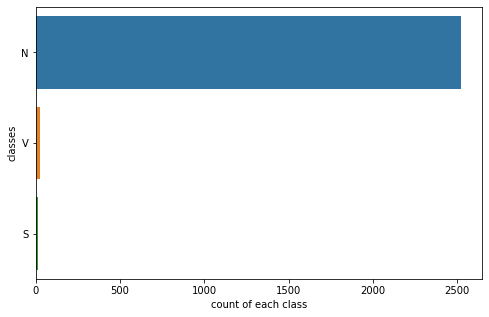

In [683]:
print(features.groupby('Target').size())  # print class frequency
sns.countplot(y = features.Target , data = features)
plt.xlabel("count of each class")
plt.ylabel("classes")
plt.show()  # visualize class counts

###DATA BALANCING

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(feat, y, test_size=0.2, random_state=42,
                               shuffle=True, stratify=y)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

class_weights = calculating_class_weights(y_train)

keys = np.arange(0,9,1)
weight_dictionary_fold = dict(zip(keys, class_weights.T[1]))
weight_dictionary_fold

TypeError: ignored

###NUMERICAL/CATEGORICAL VARIABLES

In [418]:
feat.dtypes

RRs mean           float64
RRs median         float64
RRs var            float64
RRs skew            object
RRs std            float64
RRs kurt            object
RMSSD               object
dRRs_mean          float64
dRRs_std           float64
pNN10              float64
pNN20              float64
pNN30              float64
pNN40              float64
pNN50              float64
Corr1 Ilead         object
Corr2 Ilead         object
Corrxy Ilead        object
Pdur Ilead (s)      object
Tdur Ilead (s)      object
Corr1 IIlead        object
Corr2 IIlead        object
Corrxy IIlead       object
Pdur IIlead (s)     object
Tdur IIlead (s)     object
Target              object
dtype: object

In [ ]:
count = 0
for i in feat['RRs skew']:
  feat['RRs skew'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['RRs kurt']:
  feat['RRs kurt'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['RMSSD']:
  feat['RMSSD'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['Corr1 Ilead']:
  feat['Corr1 Ilead'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['Corr2 Ilead']:
  feat['Corr2 Ilead'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['Corrxy Ilead']:
  feat['Corrxy Ilead'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['Pdur Ilead (s)']:
  feat['Pdur Ilead (s)'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['Tdur Ilead (s)']:
  feat['Tdur Ilead (s)'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['Corr1 IIlead']:
  feat['Corr1 IIlead'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['Corr2 IIlead']:
  feat['Corr2 IIlead'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['Corrxy IIlead']:
  feat['Corrxy IIlead'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['Pdur IIlead (s)']:
  feat['Pdur IIlead (s)'][count] = re.sub("[\[\]]","", i)
  count = count+1

count = 0
for i in feat['Tdur IIlead (s)']:
  feat['Tdur IIlead (s)'][count] = re.sub("[\[\]]","", i)
  count = count+1

In [432]:
feat = feat.astype({'RRs skew':'float','RRs kurt':'float','RMSSD':'float',
                    'Corr1 Ilead':'float','Corr2 Ilead':'float','Corrxy Ilead':'float','Pdur Ilead (s)':'float','Tdur Ilead (s)':'float',
                    'Corr1 IIlead':'float','Corr2 IIlead':'float','Corrxy IIlead':'float','Pdur IIlead (s)':'float','Tdur IIlead (s)':'float'}) # converts into categorical variables

In [433]:
feat.dtypes

RRs mean           float64
RRs median         float64
RRs var            float64
RRs skew           float64
RRs std            float64
RRs kurt           float64
RMSSD              float64
dRRs_mean          float64
dRRs_std           float64
pNN10              float64
pNN20              float64
pNN30              float64
pNN40              float64
pNN50              float64
Corr1 Ilead        float64
Corr2 Ilead        float64
Corrxy Ilead       float64
Pdur Ilead (s)     float64
Tdur Ilead (s)     float64
Corr1 IIlead       float64
Corr2 IIlead       float64
Corrxy IIlead      float64
Pdur IIlead (s)    float64
Tdur IIlead (s)    float64
Target              object
dtype: object

In [434]:
y = pd.factorize(feat['Target'])[0] 
feat['Target'] = y
feat

###SET SEED FOR REPRODUCIBILITY

In [ ]:
SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

###TRAIN/VALIDATION SPLIT

Splitting in the right way is very important. When developing a model we hipotetically wants the validation set as similar as possible as the test in order to have consinstent results. Since most of the times the test set is not accessible we have to infer about its carachterstics. In this case we split manteining the same distribution of labels between training and validation in order to obtain balanced data set divisions which helps classifiers in generalizing information. This method is called stratification.

(2044, 24) (511, 24)


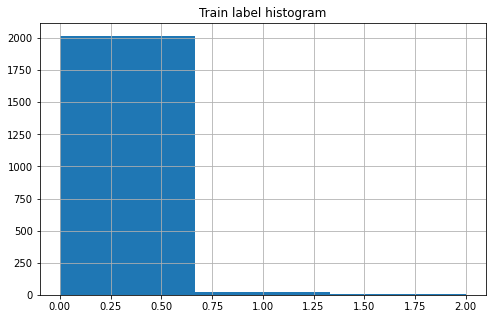

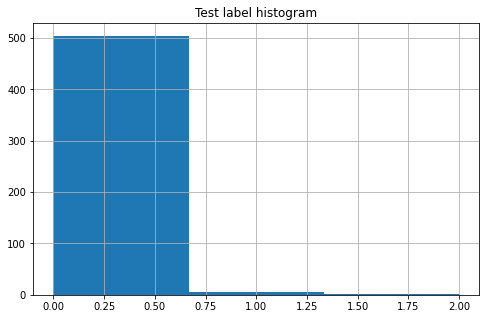

In [437]:
train, test = train_test_split(feat, test_size=0.2, random_state=SEED,
                               shuffle=True, stratify=y)
train_labels = train.Target
train_features = train.drop(columns='Target')

test_labels = test.Target
test_features = test.drop(columns='Target')

# plot label histograms 
train.hist(column = 'Target', bins = 3)
plt.title('Train label histogram')

test.hist(column = 'Target', bins = 3)
plt.title('Test label histogram')

print(train_features.shape, test_features.shape)

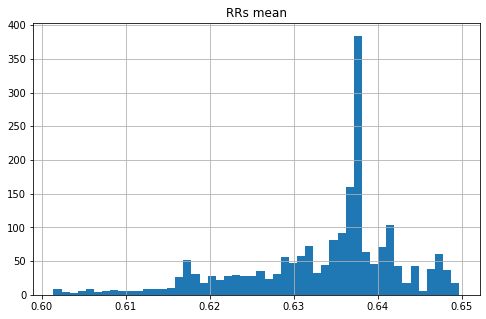

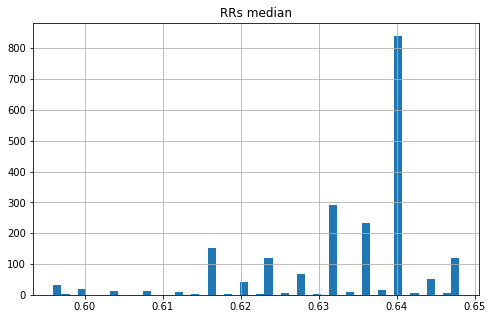

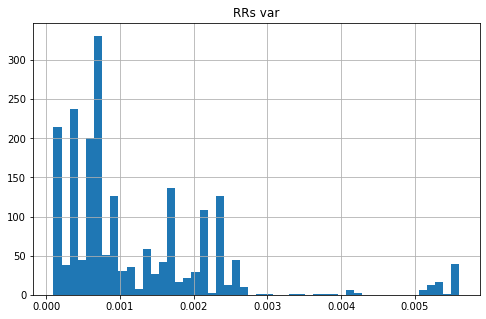

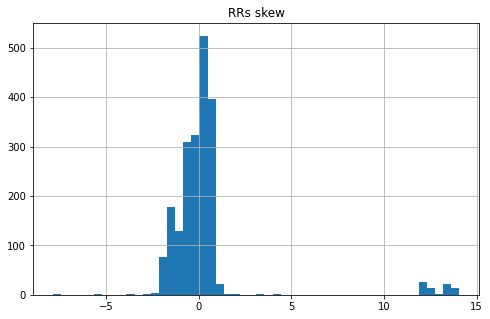

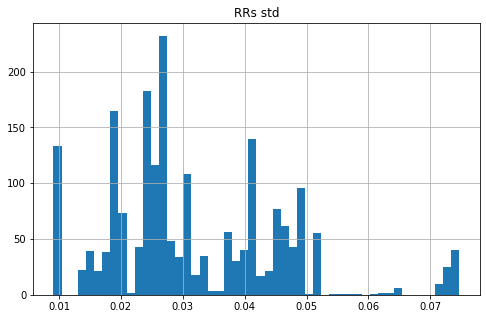

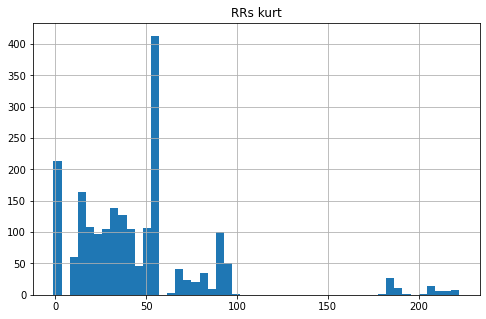

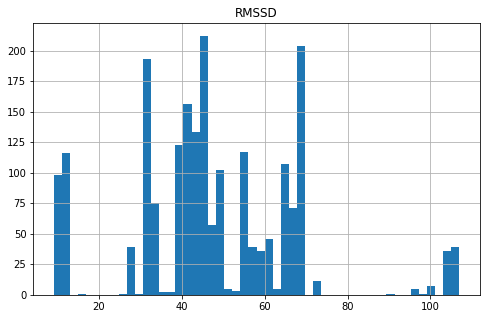

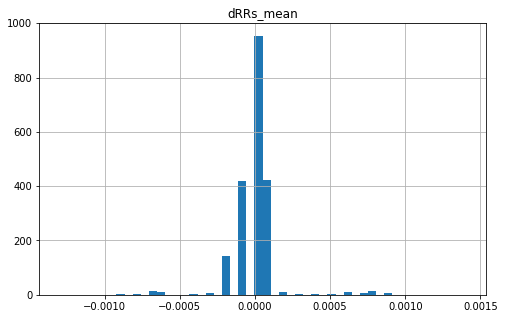

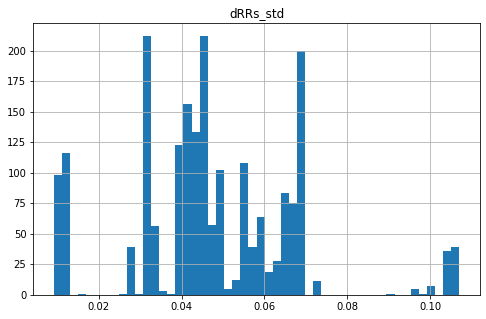

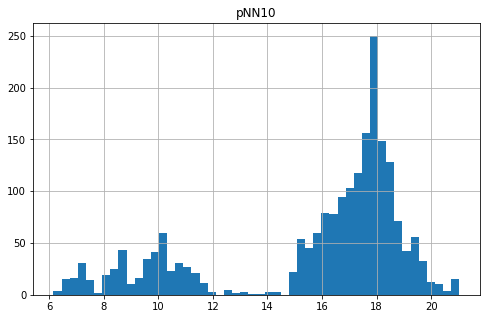

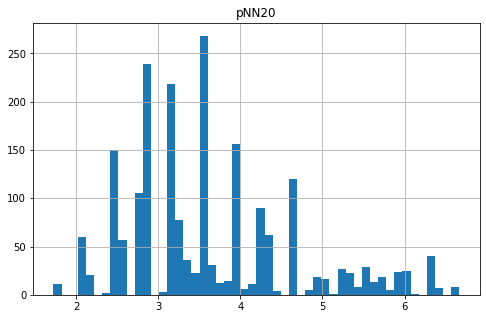

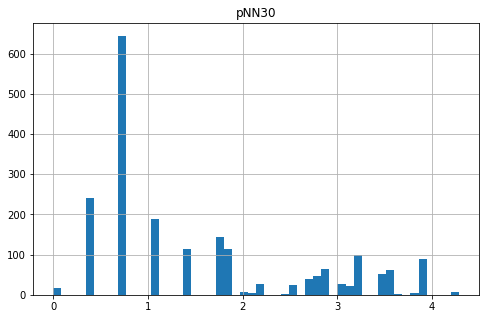

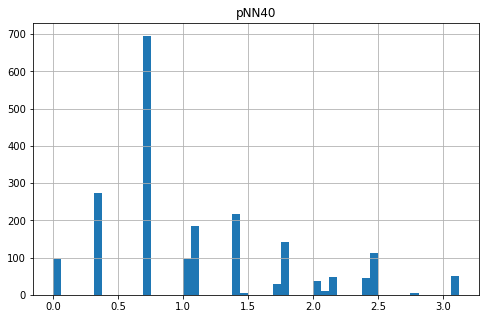

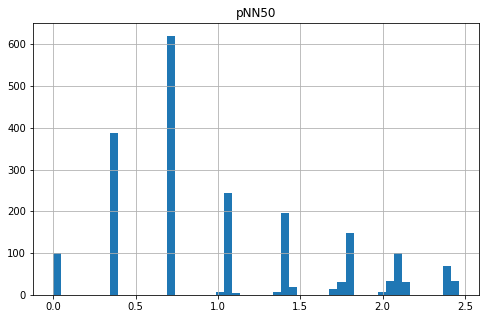

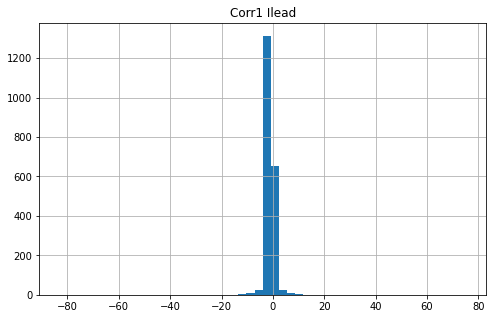

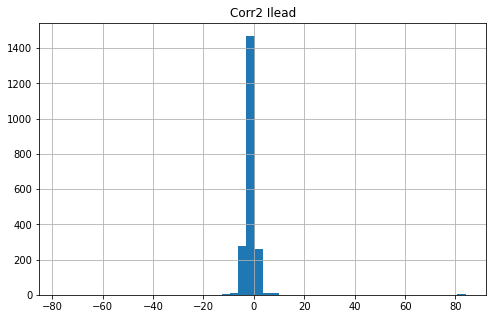

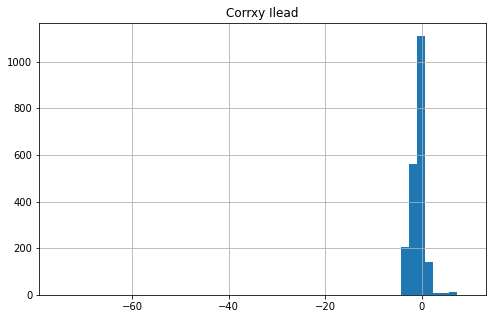

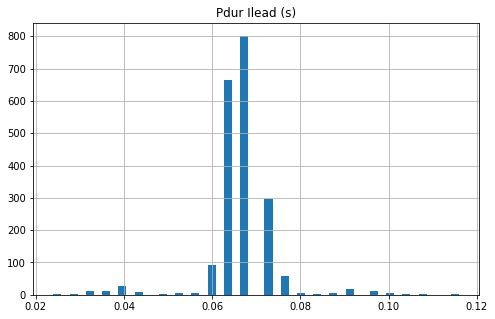

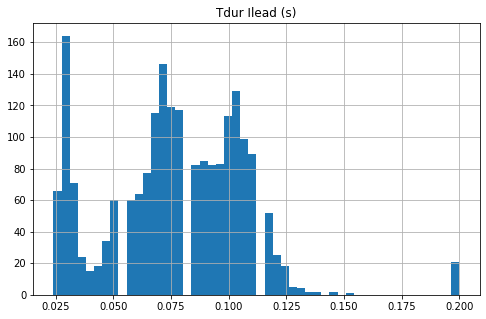

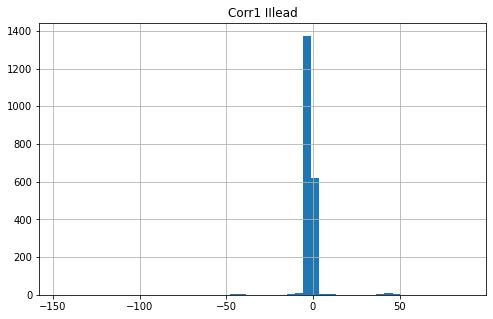

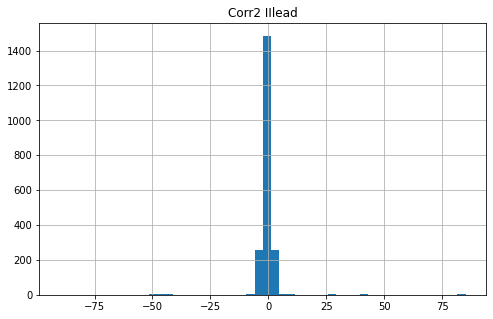

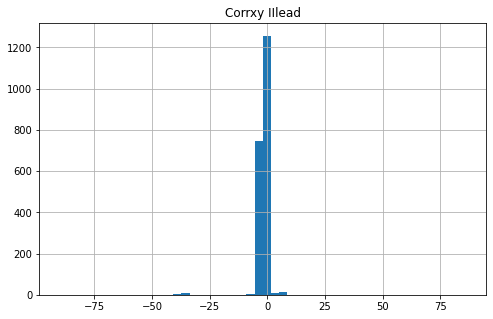

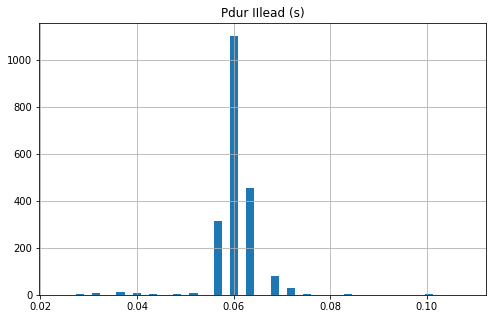

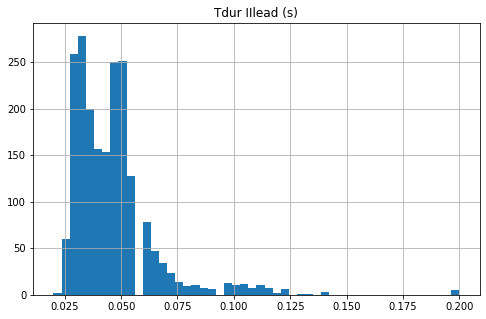

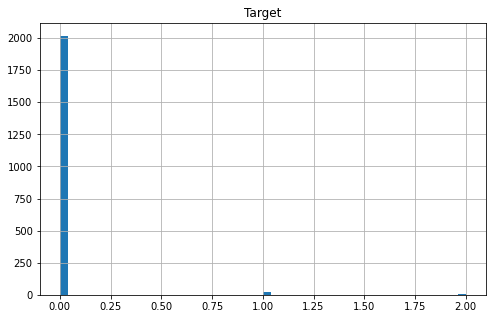

In [438]:
# 3. Visualize data distribution for each feature
for col in train.columns: 
      train.hist(column = col, bins = 50)

###MACHINE LEARNING

####MODEL SELECTION

Random Forest is a supervised tree-based ensemble machine learning model trained with the "bagging" method. The concept behind bagging is that the combination of several weak simple classifiers can lead to high performance. RF builds a strong classifier by adding together simple decision trees. A strong advantage of this methodology is its resistance toward over-fitting which is of great importance to reduce patient and database-dependent bias and ensuring the extrapolation of the model to other scenarios.

#####Baseline Model Evaluation (Feature Scaling)

In [439]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def plot_confusionMatrix(test_labels, test_predicted, clf):
  cm = confusion_matrix(test_labels, test_predicted, labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['N', 'S', 'V'])
  disp.plot()
  plt.show()
  return 

def testModel(train_features, train_labels, test_features, test_labels, clf):
  clf.fit(train_features, train_labels)

  # d. Predit test labels
  test_predicted = clf.predict(test_features)

  # e. plot confusion matrix
  plot_confusionMatrix(test_labels, test_predicted, clf)

  # f. display classification results
  print(classification_report(test_labels, test_predicted, target_names=['N', 'S', 'V']))

In [440]:
forest = RandomForestClassifier(criterion = 'entropy', max_depth = 10, min_samples_leaf = 10, min_samples_split = 10, n_estimators = 10)

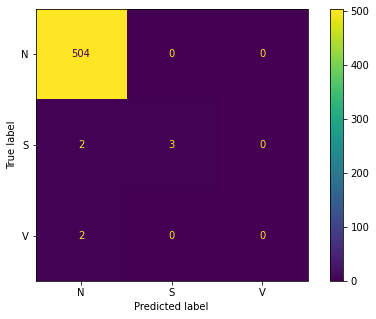

              precision    recall  f1-score   support

           N       0.99      1.00      1.00       504
           S       1.00      0.60      0.75         5
           V       0.00      0.00      0.00         2

    accuracy                           0.99       511
   macro avg       0.66      0.53      0.58       511
weighted avg       0.99      0.99      0.99       511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [441]:
testModel(train_features, train_labels, test_features, test_labels, forest)

######Outlier Removal

Evaluate baseline model after performing z-scoring for outlier removal: (score - mean)/std

In [442]:
"Given functions"
def plot_outliersAnalysis(abs_zscores):
  # number of outliers per subject 
  bool_zscores = (abs_zscores > 3).sum(axis=1)
  bool_zscores.hist()
  plt.title("Number of outliers per subject")
  plt.show()

  # number of outliers per feature 
  bool_zscores = (abs_zscores > 3).sum(axis=0)
  #bool_zscores.hist(bins = len(feature_list))
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])

  ax.bar(feature_list,bool_zscores)
  plt.title("Number of outliers per feature")
  plt.xticks(np.arange(len(feature_list)), feature_list,rotation=90)
  plt.show()
  return

Train subjects before outlier removal: (2044, 24)
Train subjects after outlier removal: (2044, 24)


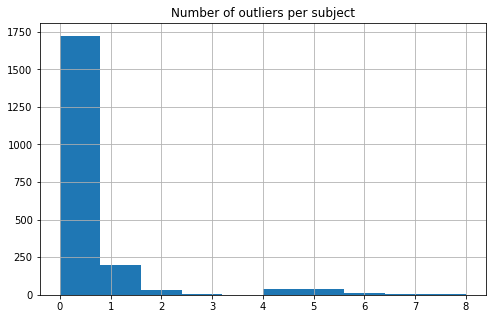

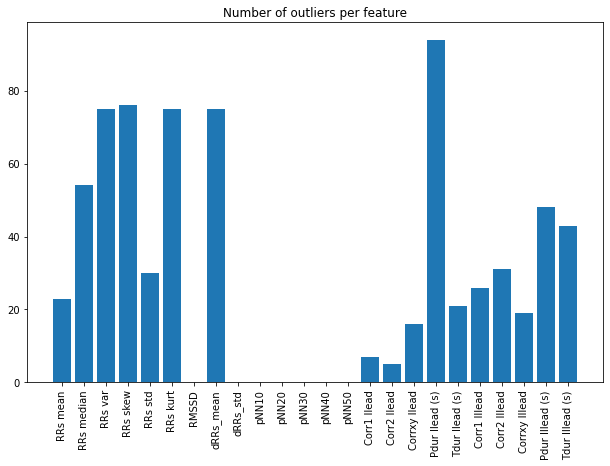

,RRs mean,RRs median,RRs var,RRs skew,RRs std,RRs kurt,RMSSD,dRRs_mean,dRRs_std,pNN10,pNN20,pNN30,pNN40,pNN50,Corr1 Ilead,Corr2 Ilead,Corrxy Ilead,Pdur Ilead (s),Tdur Ilead (s),Corr1 IIlead,Corr2 IIlead,Corrxy IIlead,Pdur IIlead (s),Tdur IIlead (s)
2288,0.6367,0.640,0.0009,0.3585,0.0298,37.2543,49.3568,-0.0002,0.0495,16.7857,3.5714,1.0714,1.0714,1.0714,1.0,0.0,0.0,0.064,0.108,0.0,0.0,0.0,0.060,0.044
1106,0.6314,0.632,0.0007,-0.3489,0.0269,55.4656,45.5195,0.0000,0.0455,18.3746,3.1802,0.7067,0.7067,0.7067,0.0,-3.0,-2.0,0.064,0.040,-1.0,-3.0,-2.0,0.064,0.048
2192,0.6375,0.640,0.0004,0.8612,0.0189,93.7120,31.0827,-0.0000,0.0312,17.8571,2.5000,0.3571,0.3571,0.3571,-1.0,0.0,-1.0,0.064,0.108,-1.0,0.0,-2.0,0.060,0.060
1873,0.6372,0.636,0.0006,0.3625,0.0245,56.3955,41.2032,0.0000,0.0412,15.7143,3.5714,0.7143,0.7143,0.7143,0.0,-2.0,-1.0,0.064,0.056,0.0,-1.0,-1.0,0.060,0.028
481,0.6422,0.640,0.0010,-1.8687,0.0319,49.1895,54.2445,-0.0001,0.0542,10.4317,5.7554,3.5971,1.4388,1.0791,-2.0,0.0,0.0,0.068,0.108,-1.0,0.0,-3.0,0.060,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,0.6228,0.624,0.0001,-0.3835,0.0097,0.8342,11.3886,0.0001,0.0112,17.4216,2.4390,0.6969,0.6969,0.3484,-1.0,0.0,-2.0,0.064,0.096,0.0,0.0,-2.0,0.060,0.052
1966,0.6378,0.640,0.0006,0.2958,0.0245,56.2382,41.2624,0.0001,0.0413,17.7936,3.5587,0.7117,0.7117,0.7117,0.0,0.0,1.0,0.068,0.116,0.0,0.0,0.0,0.060,0.068
1772,0.6357,0.636,0.0019,0.6320,0.0441,36.0913,64.8898,-0.0001,0.0648,14.9466,3.9146,1.7794,1.7794,1.7794,-1.0,-2.0,0.0,0.064,0.104,-1.0,-2.0,-1.0,0.060,0.096
1942,0.6377,0.640,0.0006,0.3103,0.0245,55.9158,41.2947,-0.0001,0.0413,17.1429,3.5714,0.7143,0.7143,0.7143,1.0,-1.0,0.0,0.064,0.104,1.0,0.0,0.0,0.060,0.040


In [443]:
from scipy.stats import zscore
import numpy as np

feature_list = train_features.columns.tolist()
print('Train subjects before outlier removal: ' + str(train_features.shape))

# apply zscore
zscore_features = train_features.apply(zscore, axis=0)

# select all those values with zscore < -+ 3 and discard outliers 
abs_zscores = np.abs(zscore_features)
filtered_entries = (abs_zscores < 3).all(axis=1)

train_features_or = train_features[filtered_entries]
train_labels_or = train_labels[filtered_entries]

print('Train subjects after outlier removal: ' + str(train_features.shape))


plot_outliersAnalysis(abs_zscores)
display(train_features)

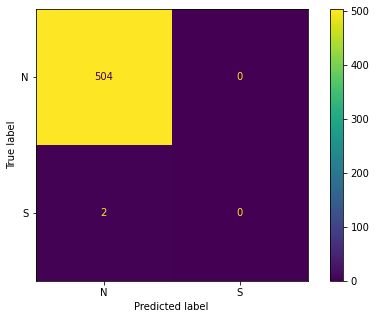

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       504
           S       0.00      0.00      0.00         5
           V       0.00      0.00      0.00         2

    accuracy                           0.99       511
   macro avg       0.33      0.33      0.33       511
weighted avg       0.97      0.99      0.98       511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [444]:
testModel(train_features_or, train_labels_or, test_features, test_labels, forest)

In order to have comparable values for the signals in input it is necessary to normalize them.

######Standardization

Evaluate baseline model after performing z-scoring for data standarization: (score - mean)/std

In [445]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(train_features_or)
train_features_zscore = transformer.transform(train_features_or)
train_features_zscore = pd.DataFrame(data=train_features_zscore, columns=feature_list)

# adapt test set
test_features_zscore = transformer.transform(test_features)
test_features_zscore = pd.DataFrame(data=test_features, columns=feature_list)

display(train_features_zscore)

,RRs mean,RRs median,RRs var,RRs skew,RRs std,RRs kurt,RMSSD,dRRs_mean,dRRs_std,pNN10,pNN20,pNN30,pNN40,pNN50,Corr1 Ilead,Corr2 Ilead,Corrxy Ilead,Pdur Ilead (s),Tdur Ilead (s),Corr1 IIlead,Corr2 IIlead,Corrxy IIlead,Pdur IIlead (s),Tdur IIlead (s)
0,0.285553,0.613260,-0.100901,0.634197,0.062808,-0.142371,0.328045,-2.186598,0.336487,0.249707,0.003467,-0.328757,0.062476,0.202744,1.325301,0.672594,0.991044,-0.770000,1.170816,0.699044,0.675856,1.441125,-0.248094,-0.003939
1,-0.375112,-0.338122,-0.378683,-0.319320,-0.190318,0.556405,0.104381,0.094033,0.103353,0.697442,-0.383088,-0.670431,-0.456567,-0.389030,0.673253,-1.335857,-0.778347,-0.770000,-1.258619,0.035087,-1.416099,-0.034272,1.012135,0.278702
2,0.385276,0.613260,-0.795355,1.311794,-0.888597,2.023939,-0.737095,0.094033,-0.730100,0.551616,-1.055212,-0.997959,-0.954119,-0.956302,0.021205,0.672594,0.106348,-0.770000,1.170816,0.035087,0.675856,-0.034272,-0.248094,1.126627
3,0.347880,0.137569,-0.517573,0.639588,-0.399802,0.592086,-0.147203,0.094033,-0.147265,-0.052202,0.003467,-0.663311,-0.445750,-0.376698,0.673253,-0.666373,0.106348,-0.770000,-0.686987,0.699044,-0.021462,0.703427,-0.248094,-1.134505
4,0.971148,0.613260,0.037989,-2.367884,0.246106,0.315588,0.612934,-1.046282,0.610419,-1.540781,2.161535,2.037480,0.585361,0.215238,-0.630843,0.672594,0.991044,0.237553,1.170816,0.035087,0.675856,-0.771970,-0.248094,-0.851864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,-1.447135,-1.289504,-1.212027,-0.365958,-1.691617,-1.539829,-1.885003,1.234348,-1.895768,0.428897,-1.115488,-0.679613,-0.470514,-0.970419,0.021205,0.672594,-0.778347,-0.770000,0.742092,0.699044,0.675856,-0.034272,-0.248094,0.561344
1718,0.422672,0.613260,-0.517573,0.549682,-0.399802,0.586050,-0.143752,1.234348,-0.141437,0.533722,-0.009083,-0.665747,-0.449451,-0.380916,0.673253,0.672594,1.875739,0.237553,1.456632,0.699044,0.675856,1.441125,-0.248094,1.691909
1719,0.160899,0.137569,1.288005,1.002852,1.310980,-0.186996,1.233416,-1.046282,1.228223,-0.268531,0.342592,0.334542,1.070104,1.351567,0.021205,-0.666373,0.991044,-0.770000,1.027908,0.035087,-0.718780,0.703427,-0.248094,3.670400
1720,0.410206,0.613260,-0.517573,0.569227,-0.399802,0.573680,-0.141869,-1.046282,-0.141437,0.350362,0.003467,-0.663311,-0.445750,-0.376698,1.325301,0.003110,0.991044,-0.770000,1.027908,1.363001,0.675856,1.441125,-0.248094,-0.286581


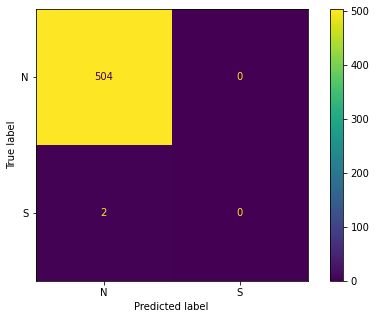

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       504
           S       0.00      0.00      0.00         5
           V       0.00      0.00      0.00         2

    accuracy                           0.99       511
   macro avg       0.33      0.33      0.33       511
weighted avg       0.97      0.99      0.98       511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [446]:
testModel(train_features_zscore, train_labels_or, test_features_zscore, test_labels, forest)

######Scaling

Evaluate baseline model after scaling data using Robust scaler: (score – median)/(p75 – p25)

Training features: (1722, 24)


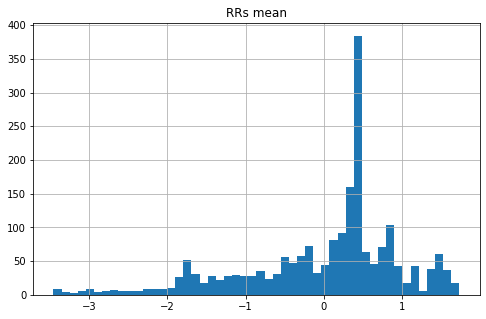

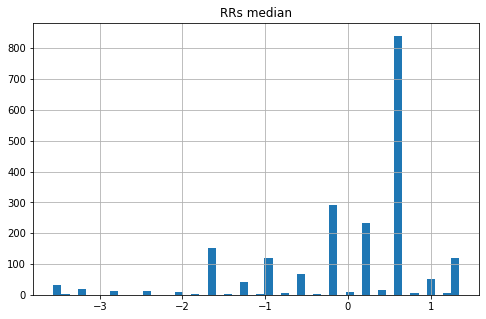

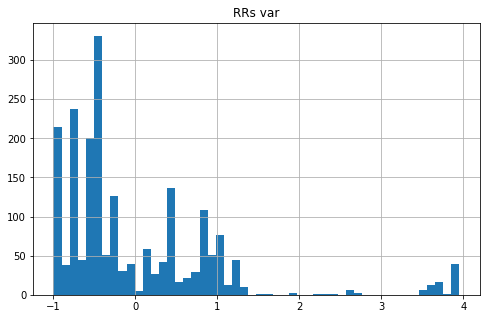

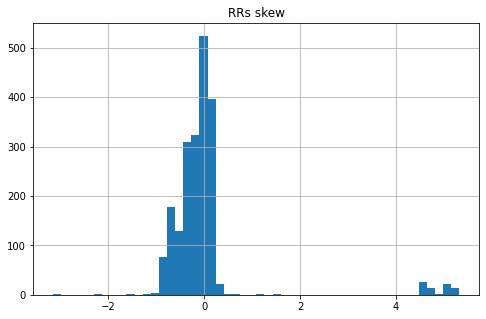

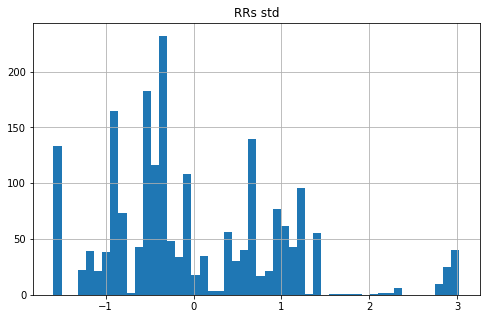

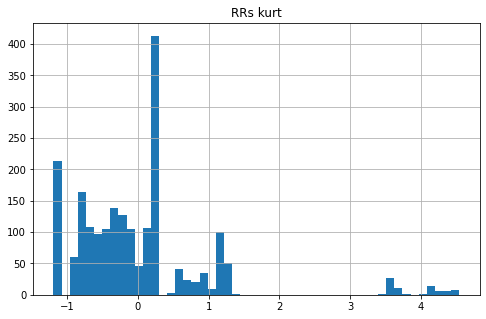

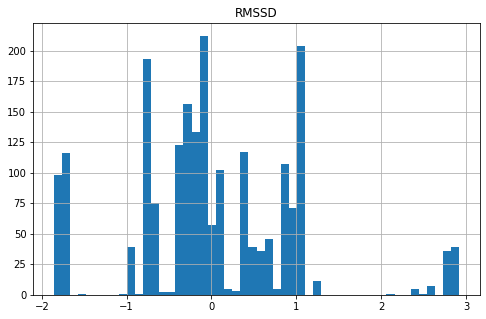

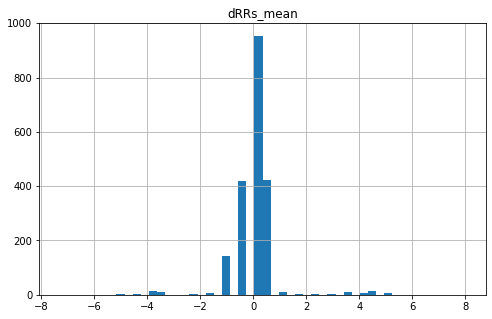

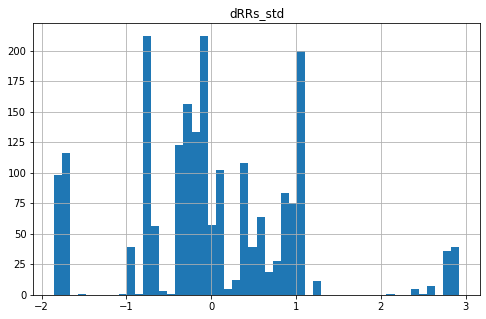

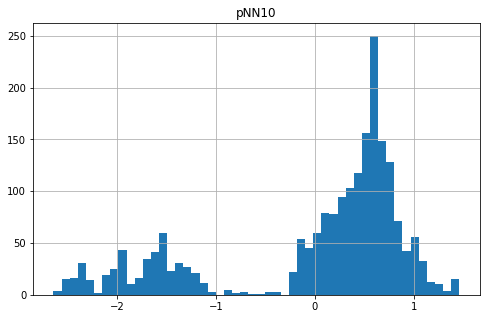

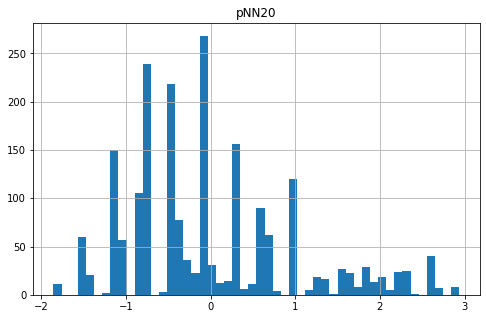

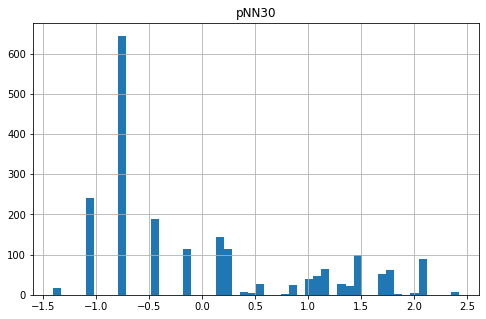

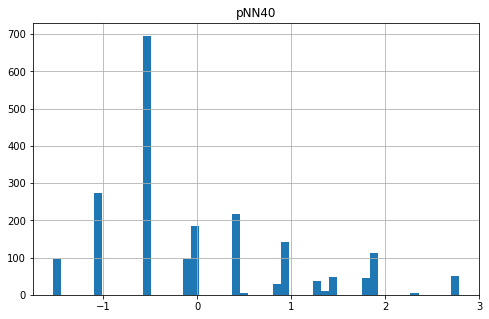

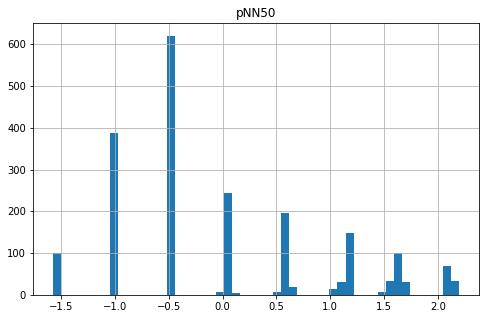

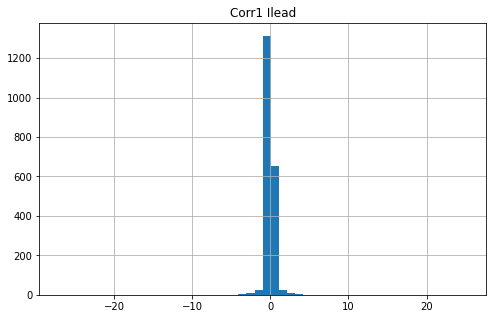

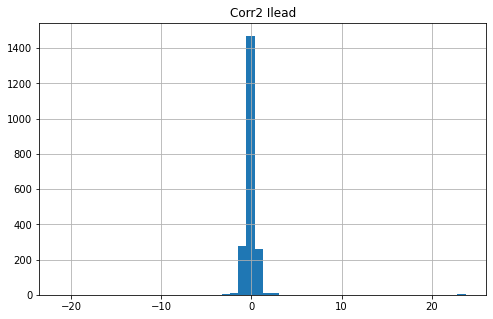

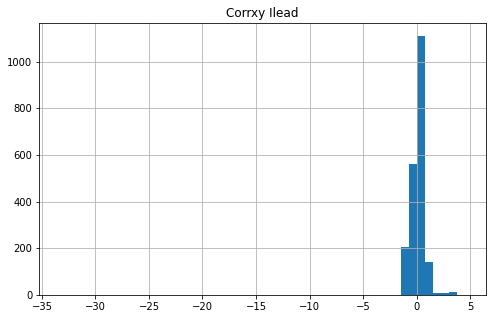

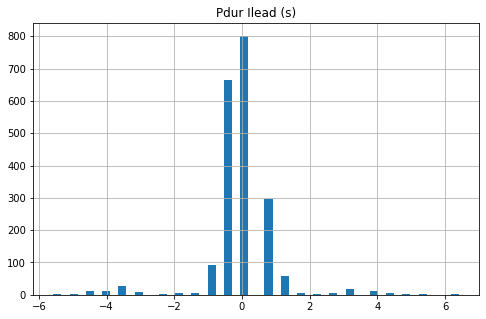

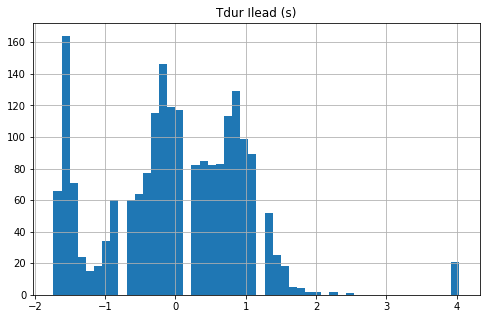

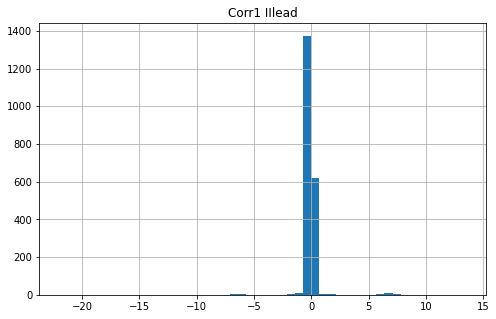

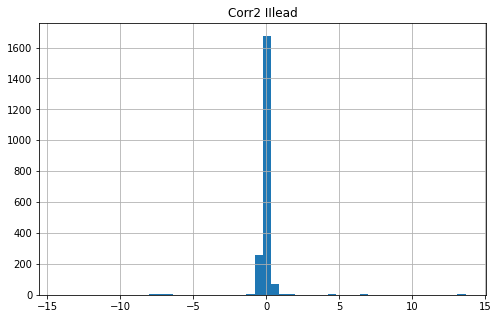

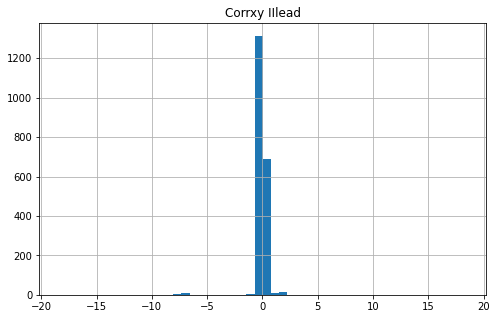

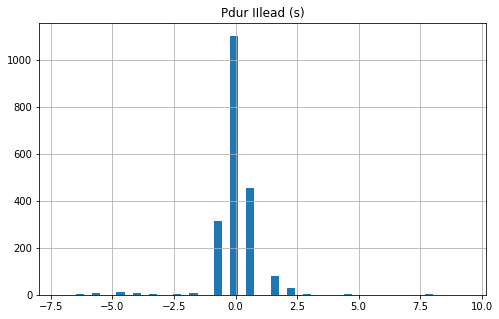

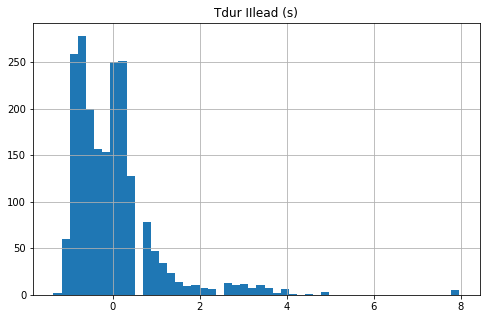

In [447]:
from sklearn.preprocessing import RobustScaler
feature_list = train_features_or.columns.tolist()


print('Training features: ' + str(train_features_or.shape))

transformer = RobustScaler().fit(train_features_or)
train_features_rs = transformer.transform(train_features_or)
for col in zscore_features.columns: 
     zscore_features.hist(column = col, bins = 50)

train_features_rs = pd.DataFrame(data=train_features_rs, columns=feature_list)

# adapt test set
test_features_rs = transformer.transform(test_features)
test_features_rs = pd.DataFrame(data=test_features_rs, columns=feature_list)

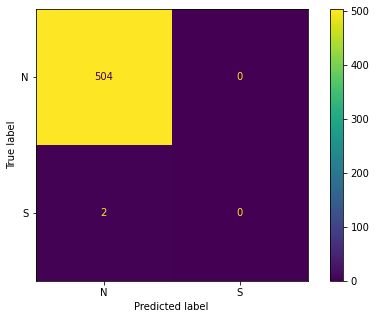

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       504
           S       0.00      0.00      0.00         5
           V       0.00      0.00      0.00         2

    accuracy                           0.99       511
   macro avg       0.33      0.33      0.33       511
weighted avg       0.97      0.99      0.98       511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [448]:
testModel(train_features_rs, train_labels_or, test_features_rs, test_labels, forest)

#####Baseline Model Evaluation (Feature Selection)

######Low variance

In [449]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

# 1. Eliminate low variance features
train_features = train_features_rs
train_labels = train_labels_or
test_features = test_features_rs


vt = VarianceThreshold(threshold=(0.01)) # eliminate constant features 
train_features_var = vt.fit_transform(train_features)
mask = vt.get_support()

train_features = train_features.loc[:, mask]

# plot deleted features
print('Deleted features: ' + str(list(compress(feature_list, ~mask))))

Deleted features: []


######Correlation

In [450]:
def plot_correlationMatrix(correlation_matrix, features):
    f = plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, fignum=f.number)
    plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
    plt.yticks(range(len(features)), features, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16)
    # plt.tight_layout()
    return 

Deleted features: {'dRRs_std', 'Corr2 Ilead', 'pNN50', 'RMSSD', 'Corr1 IIlead', 'RRs mean', 'RRs std'}


,RRs median,RRs var,RRs skew,RRs kurt,dRRs_mean,pNN10,pNN20,pNN30,pNN40,Corr1 Ilead,Corrxy Ilead,Pdur Ilead (s),Tdur Ilead (s),Corr2 IIlead,Corrxy IIlead,Pdur IIlead (s),Tdur IIlead (s)
0,1.0,1.416667,-1.853475,-0.792467,-0.0,-2.963757,1.248643,1.990497,0.503728,-0.5,-0.5,0.0,-0.363636,0.0,-1.5,-1.0,0.6
1,-0.5,0.833333,0.655383,0.107730,-0.0,0.050971,0.571035,0.348810,0.979287,0.0,-0.5,0.0,0.545455,-1.0,0.0,0.0,0.2
2,0.5,1.416667,-1.738331,-0.795196,1.0,-2.695514,0.928565,1.664947,0.503728,0.5,0.5,0.0,0.090909,1.0,-0.5,0.0,-0.8
3,-1.0,0.000000,-0.252625,0.391717,-0.0,0.113576,-0.092252,-0.302199,-0.013946,-1.0,0.0,-1.0,-0.090909,0.0,0.0,1.0,-0.4
4,-1.0,0.833333,-0.977688,-0.524608,-1.0,-0.674149,2.413664,2.565934,2.417150,0.0,0.0,1.0,0.090909,0.5,-0.5,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,-1.0,0.833333,-0.935485,-0.526272,-1.0,-0.542861,2.413664,2.565934,2.417150,-0.5,-0.5,1.0,0.363636,-0.5,-1.0,-1.0,0.4
507,-4.0,4.083333,11.972227,4.126818,-0.0,0.083821,0.145628,1.548556,2.335267,-0.5,-1.0,0.0,0.545455,-1.5,-0.5,-1.0,0.0
508,0.0,-0.083333,0.276445,0.446438,-1.0,0.207353,0.265724,-0.293058,0.000000,1.5,1.0,0.0,0.090909,1.0,1.0,0.0,0.0
509,-1.0,0.833333,-0.997653,-0.522197,-1.0,-0.805474,2.413664,2.565934,2.417150,0.5,-0.5,-1.0,-0.090909,0.5,-0.5,-1.0,-1.0


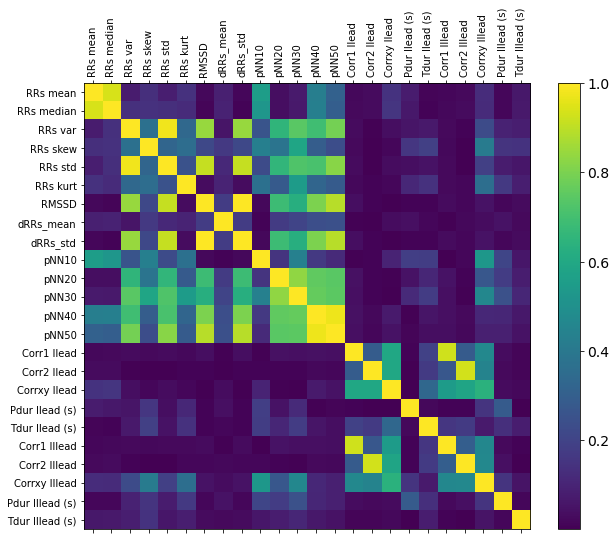

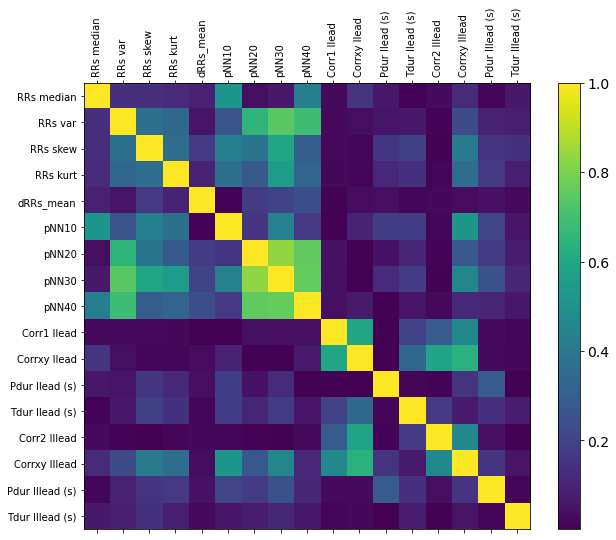

In [451]:
# 2. Eliminate correlated features
# a. visualize correlation matrix
cor_matrix = train_features.corr().abs()
plot_correlationMatrix(cor_matrix, feature_list)

# b. drop correlated features
correlated_features = set()
correlation_matrix = train_features.corr()
median_corr = (correlation_matrix.abs()).median(axis=0)

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            if median_corr[i] < median_corr[j]:
                colname = correlation_matrix.columns[i]
            else:
                colname = correlation_matrix.columns[j]
            correlated_features.add(colname)           
train_features.drop(labels=correlated_features, axis=1, inplace=True)
# see how it drops correlated / drop teh one that had a lower correlation w.r to the other feat 
print('Deleted features: ' + str(correlated_features))
"""
# drop correlated features
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
train_features = train_features.drop(columns=to_drop)
"""

# c. plot correlation matrix with remaining features
cor_matrix = train_features.corr().abs()
feature_list = list(train_features.columns)
f2 = plot_correlationMatrix(cor_matrix, feature_list)

# adapt test set: pick only selected features
test_features = test_features[feature_list]
display(test_features)

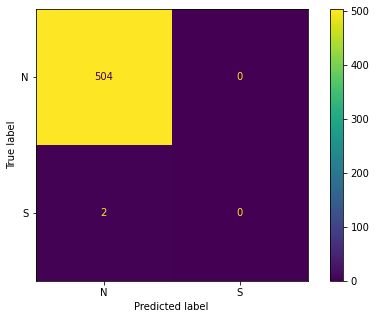

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       504
           S       0.00      0.00      0.00         5
           V       0.00      0.00      0.00         2

    accuracy                           0.99       511
   macro avg       0.33      0.33      0.33       511
weighted avg       0.97      0.99      0.98       511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [452]:
testModel(train_features, train_labels, test_features, test_labels, forest)

######Recursive elimination

In [453]:
def plot_recurrentFE(min_features_to_select, rfecv):
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (accuracy)")
  plt.plot(range(min_features_to_select,
                len(rfecv.grid_scores_) + min_features_to_select),
          rfecv.grid_scores_)
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


Optimal number of features : 1


,ranking,selected
RRs median,17,False
RRs var,14,False
RRs skew,1,True
RRs kurt,16,False
dRRs_mean,15,False
pNN10,3,False
pNN20,12,False
pNN30,4,False
pNN40,8,False
Corr1 Ilead,13,False


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score
0,0.833333,0.235702,1.0,1.0,0.5
1,0.833333,0.235702,1.0,1.0,0.5
2,0.833333,0.235702,1.0,1.0,0.5
3,0.833333,0.235702,1.0,1.0,0.5
4,0.833333,0.235702,1.0,1.0,0.5
5,0.833333,0.235702,1.0,1.0,0.5
6,0.833333,0.235702,1.0,1.0,0.5
7,0.833333,0.235702,1.0,1.0,0.5
8,0.833333,0.235702,1.0,1.0,0.5
9,0.833333,0.235702,1.0,1.0,0.5


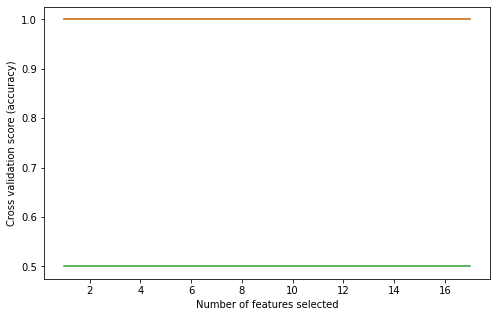

In [455]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
min_features_to_select = 1

rfecv = RFECV(estimator=forest, step=1, cv=StratifiedKFold(3),
              scoring='balanced_accuracy',
              min_features_to_select=min_features_to_select)

rfecv.fit(train_features, train_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# adapt train & test set
train_features = train_features.iloc[:, rfecv.support_]
test_features = test_features.iloc[:, rfecv.support_]

fs_results_2 = pd.DataFrame({'ranking': rfecv.ranking_, 'selected': rfecv.support_},
                              index = [rfecv.feature_names_in_])
display(fs_results_2)

fs_results_1 = pd.DataFrame(rfecv.cv_results_)
display(fs_results_1)

# Plot number of features VS. cross-validation scores
plot_recurrentFE(min_features_to_select, rfecv)

In [ ]:
testModel(train_features, train_labels, test_features, test_labels, forest)

######Principal component analysis (PCA)

In [458]:
def plot_PCAanalysis(train_features_pca, pc_plot):
  principalComponents_Df = pd.DataFrame(data = train_features_pca[:,pc_plot],
                                      columns = ['principal component 1', 'principal component 2'])
  plt.figure()
  plt.figure(figsize=(10,10))
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=14)
  plt.xlabel('Principal Component - 1',fontsize=20)
  plt.ylabel('Principal Component - 2',fontsize=20)
  plt.title("Principal Component Analysis",fontsize=20)
  targets = [0, 1, 2]
  colors = ['r', 'g', 'b']
  for target, color in zip(targets,colors):
    indicesToKeep = np.array(train_labels) == target
    plt.scatter(principalComponents_Df.loc[indicesToKeep, 'principal component 1']
                , principalComponents_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

  plt.legend(targets,prop={'size': 15})
  return

In [459]:
from sklearn.decomposition import PCA
varianceThreshold = 0.95
pca_features = PCA(n_components = varianceThreshold, random_state= 42)
pca_features.fit(train_features)

train_features_pca = pca_features.transform(train_features)
print(np.shape(train_features_pca))

pc_plot = [3, 5]

plot_PCAanalysis(train_features_pca, pc_plot)

# adapt test set
test_features_pca = pca_features.transform(test_features)
print(np.shape(test_features_pca))

(1722, 1)


IndexError: ignored

In [ ]:
testModel(train_features_pca, train_labels, test_features_pca, test_labels, forest)

####MODEL TRAINING

#####Grid hyperparameter search

In [473]:
def hyperp_search(classifier, parameters):
  gs = GridSearchCV(classifier, parameters, cv = 3, scoring = 'f1_weighted', verbose = 0, n_jobs = -1, refit=True, error_score='raise')
  # GS perfoms an exhaustive search over specified parameter values for an estimator.
  # GS uses a Stratified K-Folds cross-validator (the folds are made by preserving the percentage of samples for each class.)
  # if refit=True the model is retrained on the whole training set with the best found params
  gs = gs.fit(X_train, y_train)
  print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))
  
  global y_pred
  best_model = gs.best_estimator_
  y_pred = best_model.predict(X_test)
  
  print("f1_test: ", f1_score(y_test, y_pred, average='weighted'))

  return gs.best_params_

In [475]:
classifier = RandomForestClassifier(class_weight='balanced')
classifier.get_params().keys()
parameters = {'n_estimators': [10, 100, 1000],  # the number of trees in the forest: a higher number makes the predictions 
                                                # stronger and more stable, but a very large number can result in higher 
                                                # training time
              'criterion': ['entropy','gini'],  # the function to measure the quality of a split
              'max_depth': [10, 100, 1000],   # the maximum depth of the tree
              'min_samples_leaf': [10, 100, 1000],  # the minimum number of samples required to split an internal node
              'min_samples_split': [10, 100, 1000]}  # the minimum number of samples required to be at a leaf node
              

best_params_ = hyperp_search(classifier, parameters)
y_forest = y_pred

f1_train: 0.993642 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
f1_test:  0.9909792064994299


In [476]:
forest = RandomForestClassifier(**best_params_)

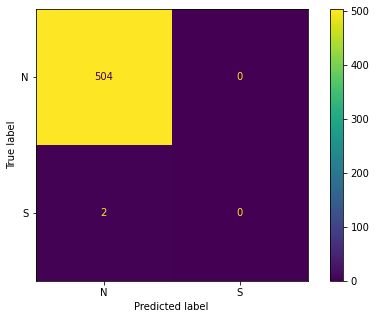

              precision    recall  f1-score   support

           N       0.99      1.00      0.99       504
           S       0.00      0.00      0.00         5
           V       0.00      0.00      0.00         2

    accuracy                           0.99       511
   macro avg       0.33      0.33      0.33       511
weighted avg       0.97      0.99      0.98       511



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [477]:
testModel(train_features, train_labels, test_features, test_labels, forest)

#####Bayesian hyperparameter search

In [478]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

"EXERCISE IV: bayesian search"
# 1. Define the values for each hyperparameter
params = {'n_estimators': [10, 100, 1000],  # the number of trees in the forest: a higher number makes the predictions 
                                                # stronger and more stable, but a very large number can result in higher 
                                                # training time
              'criterion': ['entropy','gini'],  # the function to measure the quality of a split
              'max_depth': [10, 100, 1000],   # the maximum depth of the tree
              'min_samples_leaf': [10, 100, 1000],  # the minimum number of samples required to split an internal node
              'min_samples_split': [10, 100, 1000]}

# 2. Crossvalidate model to obtain the best fit
!pip install skopt 
from skopt import BayesSearchCV
from sklearn.metrics import classification_report

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
clf = BayesSearchCV(estimator=SVC(), search_spaces=params, cv=cv, scoring='f1_macro')
clf.fit(train_features, train_labels)

for param, score in zip(clf.cv_results_['params'], clf.cv_results_['mean_test_score']):
    print(param, score)

print('Best combination of hyperparameters: ' + str(clf.best_params_))

clf_best = svm.SVC(**clf.best_params_)

ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


ModuleNotFoundError: ignored

In [ ]:
testModel(train_features, train_labels, test_features, test_labels, clf_best)

####MODELS COMPARISON

In [ ]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.datasets import fetch_california_housing

print(__doc__)

dataset = fetch_california_housing()
X_full, y_full = dataset.data, dataset.target
feature_names = dataset.feature_names

feature_mapping = {
    'MedInc': 'Median income in block',
    'HousAge': 'Median house age in block',
    'AveRooms': 'Average number of rooms',
    'AveBedrms': 'Average number of bedrooms',
    'Population': 'Block population',
    'AveOccup': 'Average house occupancy',
    'Latitude': 'House block latitude',
    'Longitude': 'House block longitude'
}

# Take only 2 features to make visualization easier
# Feature MedInc has a long tail distribution.
# Feature AveOccup has a few but very large outliers.
features = ['MedInc', 'AveOccup']
features_idx = [feature_names.index(feature) for feature in features]
X = X_full[:, features_idx]
distributions = [
    ('Unscaled data', X),
    ('Data after standard scaling',
        StandardScaler().fit_transform(X)),
    ('Data after min-max scaling',
        MinMaxScaler().fit_transform(X)),
    ('Data after max-abs scaling',
        MaxAbsScaler().fit_transform(X)),
    ('Data after robust scaling',
        RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
    ('Data after power transformation (Yeo-Johnson)',
     PowerTransformer(method='yeo-johnson').fit_transform(X)),
    ('Data after power transformation (Box-Cox)',
     PowerTransformer(method='box-cox').fit_transform(X)),
    ('Data after quantile transformation (uniform pdf)',
        QuantileTransformer(output_distribution='uniform')
        .fit_transform(X)),
    ('Data after quantile transformation (gaussian pdf)',
        QuantileTransformer(output_distribution='normal')
        .fit_transform(X)),
    ('Data after sample-wise L2 normalizing',
        Normalizer().fit_transform(X)),
]

# scale the output between 0 and 1 for the colorbar
y = minmax_scale(y_full)

# plasma does not exist in matplotlib < 1.5
cmap = getattr(cm, 'plasma_r', cm.hot_r)


def create_axes(title, figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)

    # define the axis for the first plot
    left, width = 0.1, 0.22
    bottom, height = 0.1, 0.7
    bottom_h = height + 0.15
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter = plt.axes(rect_scatter)
    ax_histx = plt.axes(rect_histx)
    ax_histy = plt.axes(rect_histy)

    # define the axis for the zoomed-in plot
    left = width + left + 0.2
    left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.1]
    rect_histy = [left_h, bottom, 0.05, height]

    ax_scatter_zoom = plt.axes(rect_scatter)
    ax_histx_zoom = plt.axes(rect_histx)
    ax_histy_zoom = plt.axes(rect_histy)

    # define the axis for the colorbar
    left, width = width + left + 0.13, 0.01

    rect_colorbar = [left, bottom, width, height]
    ax_colorbar = plt.axes(rect_colorbar)

    return ((ax_scatter, ax_histy, ax_histx),
            (ax_scatter_zoom, ax_histy_zoom, ax_histx_zoom),
            ax_colorbar)


def plot_distribution(axes, X, y, hist_nbins=50, title="",
                      x0_label="", x1_label=""):
    ax, hist_X1, hist_X0 = axes

    ax.set_title(title)
    ax.set_xlabel(x0_label)
    ax.set_ylabel(x1_label)

    # The scatter plot
    colors = cmap(y)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.5, marker='o', s=5, lw=0, c=colors)

    # Removing the top and the right spine for aesthetics
    # make nice axis layout
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))

    # Histogram for axis X1 (feature 5)
    hist_X1.set_ylim(ax.get_ylim())
    hist_X1.hist(X[:, 1], bins=hist_nbins, orientation='horizontal',
                 color='grey', ec='grey')
    hist_X1.axis('off')

    # Histogram for axis X0 (feature 0)
    hist_X0.set_xlim(ax.get_xlim())
    hist_X0.hist(X[:, 0], bins=hist_nbins, orientation='vertical',
                 color='grey', ec='grey')
    hist_X0.axis('off')

def make_plot(item_idx):
    title, X = distributions[item_idx]
    ax_zoom_out, ax_zoom_in, ax_colorbar = create_axes(title)
    axarr = (ax_zoom_out, ax_zoom_in)
    plot_distribution(axarr[0], X, y, hist_nbins=200,
                      x0_label=feature_mapping[features[0]],
                      x1_label=feature_mapping[features[1]],
                      title="Full data")

    # zoom-in
    zoom_in_percentile_range = (0, 99)
    cutoffs_X0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_X1 = np.percentile(X[:, 1], zoom_in_percentile_range)

    non_outliers_mask = (
        np.all(X > [cutoffs_X0[0], cutoffs_X1[0]], axis=1) &
        np.all(X < [cutoffs_X0[1], cutoffs_X1[1]], axis=1))
    plot_distribution(axarr[1], X[non_outliers_mask], y[non_outliers_mask],
                      hist_nbins=50,
                      x0_label=feature_mapping[features[0]],
                      x1_label=feature_mapping[features[1]],
                      title="Zoom-in")

    norm = mpl.colors.Normalize(y_full.min(), y_full.max())
    mpl.colorbar.ColorbarBase(ax_colorbar, cmap=cmap,
                              norm=norm, orientation='vertical',
                              label='Color mapping for values of y')
    
#------------------------------------------------------------------------------
"""
Each transformation is plotted showing two transformed features, with the left
plot showing the entire dataset, and the right zoomed-in to show the dataset 
without the marginal outliers. A large majority of the samples are compacted to
a specific range, [0, 10] for the median income and [0, 6] for the average 
house occupancy. Note that there are some marginal outliers (some blocks have 
average occupancy of more than 1200). Therefore, a specific pre-processing can
be very beneficial depending of the application. In the following, we present 
some insights and behaviors of those pre-processing methods in the presence 
of marginal outliers.
"""
make_plot(0)
"""
StandardScaler removes the mean and scales the data to unit variance. The scaling
shrinks the range of the feature values as shown in the left figure below. 
However, the outliers have an influence when computing the empirical mean and 
standard deviation. Note in particular that because the outliers on each feature
have different magnitudes, the spread of the transformed data on each feature 
is very different: most of the data lie in the [-2, 4] range for the transformed
median income feature while the same data is squeezed in the smaller [-0.2, 0.2]
range for the transformed average house occupancy.

StandardScaler therefore cannot guarantee balanced feature scales in the presence of outliers.
"""
make_plot(1)
"""
MinMaxScaler rescales the data set such that all feature values are in the range 
[0, 1] as shown in the right panel below. However, this scaling compresses all 
inliers into the narrow range [0, 0.005] for the transformed average house occupancy.

Both StandardScaler and MinMaxScaler are very sensitive to the presence of outliers.
"""
make_plot(2)
"""
MaxAbsScaler is similar to MinMaxScaler except that the values are mapped in the 
range [0, 1]. On positive only data, both scalers behave similarly. MaxAbsScaler
therefore also suffers from the presence of large outliers.
"""
make_plot(3)
"""
Unlike the previous scalers, the centering and scaling statistics of RobustScaler
is based on percentiles and are therefore not influenced by a few number of very 
large marginal outliers. Consequently, the resulting range of the transformed 
feature values is larger than for the previous scalers and, more importantly,
are approximately similar: for both features most of the transformed values lie
in a [-2, 3] range as seen in the zoomed-in figure. Note that the outliers 
themselves are still present in the transformed data. If a separate outlier 
clipping is desirable, a non-linear transformation is required (see below).
"""
make_plot(4)

"""
PowerTransformer applies a power transformation to each feature to make the data 
more Gaussian-like in order to stabilize variance and minimize skewness. Currently 
the Yeo-Johnson and Box-Cox transforms are supported and the optimal scaling 
factor is determined via maximum likelihood estimation in both methods. By default,
PowerTransformer applies zero-mean, unit variance normalization. Note that 
Box-Cox can only be applied to strictly positive data. Income and average house 
occupancy happen to be strictly positive, but if negative values are present the
Yeo-Johnson transformed is preferred.
"""
make_plot(5)
make_plot(6)

####SELECTED MODEL DEFINITIVE TRAINING

We now train the model on the entire data that we used for all of our evaluations so far, i.e. everything apart from the validation set. We use the hyperparameters that we found in the previous part.

In [ ]:
X = featnum_scaled
y = pd.factorize(feat['Target'])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0,
                                                    stratify = y,  # preserve target proportions 
                                                    random_state = 123)
print(X_train.shape, X_test.shape)

In [ ]:
forest.fit(X_train, y_train)

In [ ]:
model_directory= '/gdrive/MyDrive/AN_Assignment/'
filename = 'RandomForest'
filename_chosen = os.path.join(model_directory, filename)
model.save(filename_chosen + '.h5')

###DEEP LEARNING

An algorithm for automate interpretation of ECG must recognize the distinct waves and understand the relationships between them over time. This is a complex task because of the presence of noise in the signal and because of the variability in wave morphology among patients.

An important aspect in the passage from from machine learning model to deep learning is that in the latter we need more data in order to obtain good generalization.

In [481]:
import os
import numpy as np, os, sys, joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile

from scipy import optimize

from scipy.signal import butter, lfilter, filtfilt

from keras.preprocessing.sequence import pad_sequences
import math

import tensorflow as tf
from tensorflow import keras

from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model

import random

import keras.backend as K
K.set_image_data_format('channels_last')

####MODELS

In [494]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0,
                                            patience=7,
                                            verbose=0,
                                            mode="auto", 
                                            baseline=None,
                                            restore_best_weights=False,
                                            )

Stop training when a monitored metric has stopped improving.

* **monitor**: Quantity to be monitored.
* **min_delta**: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
* **patience**: Number of epochs with no improvement after which training will be stopped.
verbose: verbosity mode.
* **mode**: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
* **baseline**: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
* **restore_best_weights**: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used. An epoch will be restored regardless of the performance relative to the baseline. If no epoch improves on baseline, training will run for patience epochs and restore weights from the best epoch in that set.


####FFNN

In [517]:
FFN = keras.Sequential([
    keras.layers.Input((176,1)),
    keras.layers.Dense(128, activation=tf.nn.relu),       # relu for vanishing gradient
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Flatten(),
    keras.layers.Dense(3, activation=tf.nn.softmax)   # sigmoid for binary classification
])

In [518]:
learning_rate = 0.02
FFN.compile(
    optimizer = keras.optimizers.Adam(learning_rate),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [519]:
FFN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 176, 128)          256       
                                                                 
 dense_6 (Dense)             (None, 176, 64)           8256      
                                                                 
 flatten_2 (Flatten)         (None, 11264)             0         
                                                                 
 dense_7 (Dense)             (None, 3)                 33795     
                                                                 
Total params: 42,307
Trainable params: 42,307
Non-trainable params: 0
_________________________________________________________________


#####Training

In [549]:
def extractor(wnwst_t, wnwend_t):
  wnwst_smp = round(wnwst_t*fs)           # number of samples before the R peak
  wnwend_smp = round(wnwend_t*fs)         # number of samples after the R peak
  rows = []                               # list initialization
  ECG_wnw = []                            # list initialization
  ECG = 0                                 # ECGs are stored in the first column of the data matrix
  Ilead = 0                               # I lead is stored in the first column of the ECGs
  IIlead = 1                              # II lead is stored in the second column of the ECGs
  Rpks = 1                                # Rpks are stored in the second column of the data matrix
  anns = 2                                # anns are stored in the third column of the data matrix

  for patient in range(1):
    print(patient)
    rows = []
    ECGIupblr_filt = dataupblr_filt[patient][ECG][Ilead]
    rpeaks = np.hstack(dataupblr_filt[patient][Rpks])
    rpeaks = rpeaks.astype(int)
    _, waves_dwtI = nk.ecg_delineate(ECGIupblr_filt, rpeaks, sampling_rate=250, method="dwt", show=False, show_type='all')
    ECGIIupblr_filt = dataupblr_filt[patient][ECG][IIlead]
    rpeaks = np.hstack(dataupblr_filt[patient][Rpks])
    rpeaks = rpeaks.astype(int)
    _, waves_dwtII = nk.ecg_delineate(ECGIIupblr_filt, rpeaks, sampling_rate=250, method="dwt", show=False, show_type='all')
    for n_beat, i in enumerate(rpeaks):
      ann = dataupblr_filt[patient][anns][n_beat]
      if (i-wnwst_smp)>0 and (i+wnwend_smp)<rpeaks[-1]:
        R = rpeaks[n_beat]
        R_t = R*delta_fs
        time = np.linspace((R_t-wnwst_t), (R_t+wnwend_t), wnwst_smp+wnwend_smp, endpoint=True)       
        PonI = waves_dwtI['ECG_P_Onsets'][n_beat]
        PonI = np.nan_to_num(PonI, nan=int(rpeaks[n_beat]-0.2*fs))
        PonI = PonI.astype(int)
        PpkI = waves_dwtI['ECG_P_Peaks'][n_beat]
        PpkI = np.nan_to_num(PpkI, nan=int(rpeaks[n_beat]-0.162*fs))
        PpkI = PpkI.astype(int)
        PoffI = waves_dwtI['ECG_P_Offsets'][n_beat]
        PoffI = np.nan_to_num(PoffI, nan=int(rpeaks[n_beat]-0.125*fs))
        PoffI = PoffI.astype(int)
        QI = waves_dwtI['ECG_Q_Peaks'][n_beat]
        QI = np.nan_to_num(QI, nan=int(rpeaks[n_beat]-0.05*fs))
        QI = QI.astype(int)
        RonI = waves_dwtI['ECG_R_Onsets'][n_beat]
        RonI = np.nan_to_num(RonI, nan=int(rpeaks[n_beat]-0.02*fs))
        RonI = RonI.astype(int)
        RoffI = waves_dwtI['ECG_R_Offsets'][n_beat]
        RoffI = np.nan_to_num(RoffI, nan=int(rpeaks[n_beat]+0.02*fs))
        RoffI = RoffI.astype(int)
        SI = waves_dwtI['ECG_S_Peaks'][n_beat]
        SI = np.nan_to_num(SI, nan=int(rpeaks[n_beat]+0.05*fs))
        SI = SI.astype(int)
        TonI = waves_dwtI['ECG_T_Onsets'][n_beat]
        TonI = np.nan_to_num(TonI, nan=int(rpeaks[n_beat]+0.105*fs))
        TonI = TonI.astype(int)
        TpkI = waves_dwtI['ECG_T_Peaks'][n_beat]
        TpkI = np.nan_to_num(TpkI, nan=int(rpeaks[n_beat]+0.195*fs))
        TpkI = TpkI.astype(int)
        ToffI = waves_dwtI['ECG_T_Offsets'][n_beat]
        ToffI = np.nan_to_num(ToffI, nan=int(rpeaks[n_beat]+0.305*fs))
        ToffI = ToffI.astype(int)
        PonII = waves_dwtII['ECG_P_Onsets'][n_beat]
        PonII = np.nan_to_num(PonII, nan=int(rpeaks[n_beat]-0.2*fs))
        PonII = PonII.astype(int)
        PpkII = waves_dwtII['ECG_P_Peaks'][n_beat]
        PpkII = np.nan_to_num(PpkII, nan=int(rpeaks[n_beat]-0.162*fs))
        PpkII = PpkII.astype(int)
        PoffII = waves_dwtII['ECG_P_Offsets'][n_beat]
        PoffII = np.nan_to_num(PoffII, nan=int(rpeaks[n_beat]-0.125*fs))
        PoffII = PoffII.astype(int)
        QII = waves_dwtII['ECG_Q_Peaks'][n_beat]
        QII = np.nan_to_num(QII, nan=int(rpeaks[n_beat]-0.05*fs))
        QII = QII.astype(int)
        RonII = waves_dwtII['ECG_R_Onsets'][n_beat]
        RonII = np.nan_to_num(RonII, nan=int(rpeaks[n_beat]-0.02*fs))
        RonII = RonII.astype(int)
        RoffII = waves_dwtII['ECG_R_Offsets'][n_beat]
        RoffII = np.nan_to_num(RoffII, nan=int(rpeaks[n_beat]+0.02*fs))
        RoffII = RoffII.astype(int)
        SII = waves_dwtII['ECG_S_Peaks'][n_beat]
        SII = np.nan_to_num(SII, nan=int(rpeaks[n_beat]+0.05*fs))
        SII = SII.astype(int)
        TonII = waves_dwtII['ECG_T_Onsets'][n_beat]
        TonII = np.nan_to_num(TonII, nan=int(rpeaks[n_beat]+0.105*fs))
        TonII = TonII.astype(int)
        TpkII = waves_dwtII['ECG_T_Peaks'][n_beat]
        TpkII = np.nan_to_num(TpkII, nan=int(rpeaks[n_beat]+0.195*fs))
        TpkII = TpkII.astype(int)
        ToffII = waves_dwtII['ECG_T_Offsets'][n_beat]
        ToffII = np.nan_to_num(ToffII, nan=int(rpeaks[n_beat]+0.305*fs))
        ToffII = ToffII.astype(int)
        row = [ ECGIupblr_filt[i-wnwst_smp:i+wnwend_smp], ann ]
        rows.append(row)
    #lst = copy.deepcopy(rows)
    #perpatient = [ patient, lst ]
    #ECG_wnw.append(perpatient)

  return rows

In [550]:
ECG_wnw = extractor(wnwst_t, wnwend_t)

0


In [551]:
ECG_wnw = pd.DataFrame(ECG_wnw)
ECG_wnw

,0,1
0,"[-0.0015141007838425993, -0.008816187484409547...",N
1,"[0.027557379618531195, 0.03330580692869294, 0....",N
2,"[0.015881651334831177, 0.017480850259934164, 0...",N
3,"[-0.011835601992203036, -0.013963544901945953,...",N
4,"[-0.02278764459593913, -0.014793503880261098, ...",N
...,...,...
2843,"[0.021069387655728654, 0.026226968083460197, 0...",N
2844,"[0.02751604325002107, 0.02897467244411049, 0.0...",N
2845,"[0.03161326821978565, 0.02129719819667731, 0.0...",N
2846,"[-0.007807979023576005, -0.011036665962924271,...",N


In [552]:
y = pd.factorize(ECG_wnw[1])[0] 
ECG_wnw[1] = y

In [553]:
a = ECG_wnw[0].values.tolist()

In [554]:
y = ECG_wnw[1].values.tolist()

In [644]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(a, A, test_size=0.2, random_state=42,
                               shuffle=True, stratify=A)

print(len(X_train), len(y_train), len(X_val), len(y_val))

2278 2278 570 570


In [645]:
s = np.array(X_train)
t = np.array(y_train)
u = np.array(X_val)
v = np.array(y_val)

In [648]:
t.shape

(2278, 3)

In [634]:
labels = ['N','S','V']
num_classes = 3
num_files =len(ECG_wnw)
#@title Labels Encoding
num_classes = len(labels)
one_hot_labels = np.zeros((num_files,num_classes), dtype=np.bool)
for i, single_label in enumerate (labels):
  for j, x in enumerate(labels):
    if (x in single_label):
      one_hot_labels[i][j] = 1
one_hot_labels = one_hot_labels * 1 

In [635]:
A = one_hot_labels[:2845]

In [636]:
newrow = [1, 0, 0]
A = np.vstack([A, newrow])
A

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0]])

In [637]:
newrow = [0, 1, 0]
A = np.vstack([A, newrow])
A

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [651]:
pip install iterative-stratification

In [654]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

one_hot_labels_array = np.asarray(A)

mskf = MultilabelStratifiedKFold(n_splits=6, shuffle=True, random_state=SEED)

for train_index, val_index in mskf.split(filenames, one_hot_labels_array):
   print("TRAIN:", train_index, "VALIDATION:", val_index)

X_train, X_val = [filenames[index] for index in train_index], [filenames[index] for index in val_index]
y_train, y_val = one_hot_labels_array[train_index], one_hot_labels_array[val_index]

NameError: ignored

In [639]:
newrow = [0, 0, 1]
A = np.vstack([A, newrow])
A

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [649]:
history = FFN.fit(
    x = s,
    y = t, 
    validation_data=(u, v),
    batch_size = 64,
    epochs = 10
).history

Epoch 1/10


ValueError: ignored

#####Performance

In [ ]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="validation loss")
plt.title('Lossfunction Sequential FFN:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label="training accuracy")
plt.plot(history['val_accuracy'], label="validation accuracy")
plt.title('Accuracy Sequential FFN:')
plt.legend()

#####Evaluation

In [ ]:
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_6/'
filename = 'resNet_trained'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

There are too many parameters for these few layers. For this reason we replace the `Flatten` layer with `GlobalMaxPool1D`. This layer works as an ordinary max pooling layer for reducing the input but down samples to a single value.

In [ ]:
def build_ffnn(input_shape):

    # Build the neural network layer by layer
    input_layer = tf.keras.layers.Input(shape=input_shape, name='Input')
    hidden_layer1 = tf.keras.layers.Dense(units=128, activation='relu', name='Hidden1')(input_layer)
    hidden_layer2 = tf.keras.layers.Dense(units=64, activation='relu', name='Hidden2')(hidden_layer1)
    flatten = tf.keras.layers.GlobalMaxPool1D()(hidden_layer2)
    output_layer = tf.keras.layers.Dense(units=num_classes, activation='sigmoid', name='Output')(flatten)

    # Connect input and output through the Model class
    model = Model(inputs=input_layer, outputs=output_layer, name='FFNN')

    # Compile the model
    loss = 'binary_crossentropy'
    learning_rate = 0.02
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics = 'accuracy')

    # Return the model
    return model

FFN = build_ffnn((5000,12))

In [ ]:
FFN.summary()

In [ ]:
history = FFN.fit(
    x = X_train_filt,
    y = y_train, 
    validation_data=(X_val_filt, y_val),
    batch_size = 64,
    epochs = 10
).history

In [ ]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="validation loss")
plt.title('Lossfunction Functional FFN:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label="training accuracy")
plt.plot(history['val_accuracy'], label="validation accuracy")
plt.title('Accuracy Functional FFN:')
plt.legend()

####CNN

In [ ]:
cnn_model = keras.Sequential([
    keras.layers.Conv1D(filters=16, kernel_size=3, padding='same',
                        activation='relu', input_shape=(5000, 12)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv1D(filters=64, kernel_size=3,
                        padding='same', activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

In [ ]:
learning_rate = 0.001
cnn_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
cnn_model.summary()

#####Training

In [ ]:
history = cnn_model.fit(
    x = X_train_filt,
    y = y_train, 
    validation_data=(X_val_filt, y_val),
    batch_size = 64,
    epochs = 10
).history

In [ ]:
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_6/'
filename = 'resNet_trained'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

#####Performance

In [ ]:
#plot performances
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="validation loss")
plt.title('Lossfunction CNN:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label="training accuracy")
plt.plot(history['val_accuracy'], label="validation accuracy")
plt.title('Accuracy CNN:')
plt.legend()

#####Evaluation

In [ ]:
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_6/'
filename = 'resNet_trained'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

####VGG

In [ ]:
vgg = Sequential()

vgg.add(Conv1D(input_shape=(5000,12),filters=64,kernel_size=3,padding="same", activation="relu"))
vgg.add(Conv1D(filters=64,kernel_size=3,padding="same", activation="relu"))
vgg.add(MaxPooling1D(pool_size=2,strides=2))
vgg.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
vgg.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
vgg.add(MaxPooling1D(pool_size=2,strides=2))
vgg.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(Conv1D(filters=256, kernel_size=3, padding="same", activation="relu"))
vgg.add(MaxPooling1D(pool_size=2,strides=2))
vgg.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(MaxPooling1D(pool_size=2,strides=2))
vgg.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(Conv1D(filters=512, kernel_size=3, padding="same", activation="relu"))
vgg.add(MaxPooling1D(pool_size=2,strides=2))
vgg.add(keras.layers.GlobalMaxPooling1D())
vgg.add (Dense(512, activation='relu'))
vgg.add (Dropout(0.4))
vgg.add (Dense(9,activation='softmax'))


learning_rate = 0.001
vgg.compile(
    optimizer = keras.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
vgg.summary()

#####Training

In [ ]:
history = vgg.fit(
    x = batch_generator_data(batch_size=batchsize, x_gen=generate_X_shuffle(X_train), y_gen=generate_y_shuffle(y_train)),
    validation_data= validation,
    steps_per_epoch=(len(X_train)/batchsize),
    batch_size = 64,
    epochs = 20
).history

In [ ]:
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_6/'
filename = 'resNet_trained'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

#####Performance

In [ ]:
#plot performances
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="validation loss")
plt.title('Lossfunction VGG:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label="training accuracy")
plt.plot(history['val_accuracy'], label="validation accuracy")
plt.title('Accuracy VGG:')
plt.legend()

#####Evaluation

In [ ]:
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_6/'
filename = 'resNet_trained'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

####RESNET

Due to the vanishing gradient problem (as the gradient is back-propagated to earlier layers, repeated multiplication may make the gradient infinitively small), deep networks are hard to train. If the network gets very deep, performance saturates and degrades.
ResNet introduces skip connections that allow the network to go deeper without suffering form the vanishing gradient problem.

In [ ]:
def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def resnet(N=8, ch=12, win_len=5000, classes=9): 
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet) 

    # Sigmoid activation function on the last layer
    ResNet = Dense(classes, activation='sigmoid',  name='sigmoid_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input],outputs=ResNet)
    return model

In [ ]:
resNet_model = resnet(N=8, ch=12, win_len=5000, classes=9)

learning_rate = 0.001
resNet_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall' ]
)

In [ ]:
resNet_model.summary()

In [ ]:
tf.keras.utils.plot_model(
    resNet_model,
    to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

#####Training

In [ ]:
history_resNet = resNet_model.fit(
    batch_generator_data(batch_size=batchsize, x_gen=generate_X_shuffle(X_train), y_gen=generate_y_shuffle(y_train)),
    validation_data= validation,
    steps_per_epoch=(len(X_train)/batchsize),
    batch_size = 64,
    epochs = 20,
     ).history

In [ ]:
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_6/'
filename = 'resNet_trained'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

#####Performance

In [ ]:
history = history_resNet

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="validation loss")
plt.title('Lossfunction ResNet:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label="training accuracy")
plt.plot(history['val_accuracy'], label="validation accuracy")
plt.title('Accuracy ResNet:')
plt.legend()

In [ ]:
#plot performances
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['precision'], label="training precision")
plt.plot(history['val_precision'], label="validation precision")
plt.title('Precision ResNet:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['recall'], label="training recall")
plt.plot(history['val_recall'], label="validation recall")
plt.title('Recall ResNet:')
plt.legend()

#####Evaluation

In [ ]:
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_6/'
filename = 'resNet_trained'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

####WIDE RESNET

In classical machine learning approach, when performing hand-crafted feature extraction, we are explicitly providing the model with we want it to look at. 
However, in deep learning the user does not actually know exactly how the model is treating the data and what features it is focusing on.
The Wide ResNet proposes an embedded approach by merging the potential of both techniques.

In [ ]:
# model integrating deep + wide 
def resnet_deep_wide(N=8, ch=12, win_len=5000, num_wide_features= 36, classes=9): 
    # A. Wide features
    wide_input = Input(shape= (num_wide_features, ), name = 'wide_features')
    wide_branch = Dense(13, activation='relu')(wide_input)

    # B. ECG window input of shape (batch_size,  WINDOW_LEN, CHANNELS)
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # The number of filters starts from 64 and doubles every two blocks
    
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)

    shared_path = concatenate([ResNet, wide_branch], name='concat_layer')
    shared_path = Dense(classes, activation='sigmoid', name='sigmoid_classifier')(shared_path)
   
    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input,  wide_input],outputs=shared_path)

    return model

In [ ]:
resNet_deep_wide_model = resnet_deep_wide(N=8, ch=12, win_len=5000,num_wide_features= 36, classes=9)

learning_rate = 0.001
resNet_deep_wide_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall']
)

In [ ]:
resNet_deep_wide_model.summary()

In [ ]:
tf.keras.utils.plot_model(
    resNet_deep_wide_model,
    to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

#####All together

In [ ]:
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_6/'
filename = 'resNet_trained'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

#####Transfer Learning

Here we are freezing the ResNet previously computed and training only the branch related to the hand-crafted features.

In [ ]:
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_6/'
filename = 'resNet_trained'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

#####Separate Training

In [ ]:
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_6/'
filename = 'resNet_trained'
filename_chosen = os.path.join(model_directory, filename)
resNet_model.save(filename_chosen + '.h5')

####RESNET WITH SQUEEZE & EXCITATION (SE) BLOCK

1.   The function is given an input convolutional block and the current number of channels it has
2.    We squeeze each channel to a single numeric value using average pooling
3. A fully connected layer followed by a ReLU function adds the necessary nonlinearity. It’s output channel complexity is also reduced by a certain ratio.
4. A second fully connected layer followed by a Sigmoid activation gives each channel a smooth gating function.
5. At last, we weight each feature map of the convolutional block based on the result of our side network.


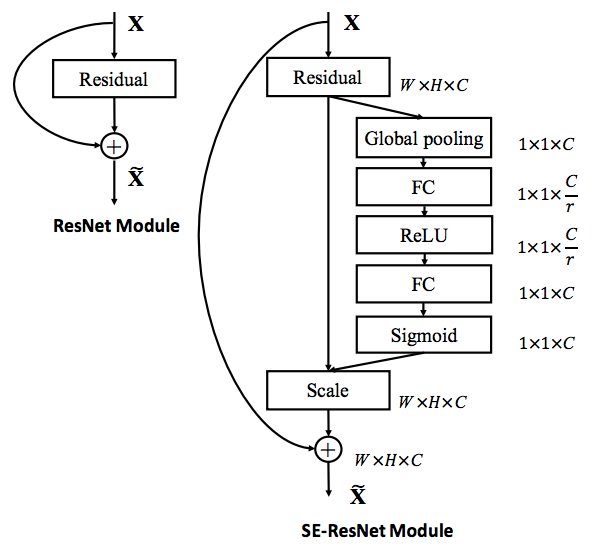

*  r: Reduction ratio
*  WxHxC: input spatial dimentions 


In [ ]:
# Squeeze and excitation module 
def se_block(in_block, ch, ratio=16):
    x = GlobalAveragePooling1D()(in_block)
    #flat = Reshape((1, num_filters))(se_pool1)
    x = Dense(ch//ratio, activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    x = multiply([in_block, x])
    return x

In [ ]:
def ResBs_SE_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = Conv1D(num_filters, kernel_size=7, strides = 2,  padding = 'same')(block_input) 
    block_input = BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. SE block (fucntion defined above)
    se = se_block(norm2, ch=num_filters)

    # 4. Summing Layer (adding a residual connection)
    sum = Add()([block_input, se])
    
    # 5. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def ResBs_SE_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. SE block (fucntion defined above)
    se = se_block(norm2, ch=num_filters)
    
    # 4. Summing Layer (adding a residual connection)
    sum = Add()([block_input, se])
    
    # 5. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

# model integrating deep + wide 
def resnet_SE_deep_wide(N=8, ch=12, win_len=5000, num_wide_features= 36, classes=9): 
    # A. Wide features
    wide_input = Input(shape= (num_wide_features, ), name = 'wide_features')
    wide_branch = Dense(13, activation='relu')(wide_input)

    # B. ECG window input of shape (batch_size,  WINDOW_LEN, CHANNELS)
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal') 

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)
    
    # B.5 ResBs (x8) blocks
    # The number of filters starts from 64 and doubles every two blocks
    
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_SE_Identity(ResNet, 64)
    ResNet = ResBs_SE_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_SE_Conv(ResNet, filters)
        ResNet = ResBs_SE_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)

    shared_path = concatenate([ResNet, wide_branch], name='concat_layer')
    shared_path = Dense(classes, activation='sigmoid', name='sigmoid_classifier')(shared_path)
   
    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[ecg_input,  wide_input],outputs=shared_path)

    return model

In [ ]:
resnet_SE_deep_wide_model = resnet_SE_deep_wide(N=8, ch=12, win_len=5000,num_wide_features= 36, classes=9)

learning_rate = 0.001
resnet_SE_deep_wide_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall']
)

In [ ]:
resNet_deep_wide_model.summary()

In [ ]:
tf.keras.utils.plot_model(
    resnet_SE_deep_wide_model,
    to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

#####Training

In [ ]:
batchsize = 64

history_resnet_SE_deep_wide= resnet_SE_deep_wide_model.fit(
    batch_generator_data_f(batch_size=batchsize, x_gen=generate_X_shuffle(X_train),f_gen= generate_F_shuffle(X_train, feature_dict_train), y_gen=generate_y_shuffle(y_train)),
    validation_data= validation,
    steps_per_epoch=(len(X_train)/batchsize),
    batch_size = 64,
    epochs = 30,
    callbacks=[callback]).history

#####Performance

In [ ]:
#plot performances
history = history_resnet_SE_deep_wide

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="validation loss")
plt.title('Lossfunction ResNet:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label="training accuracy")
plt.plot(history['val_accuracy'], label="validation accuracy")
plt.title('Accuracy ResNet:')
plt.legend()

In [ ]:
#plot performances
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['precision'], label="training precision")
plt.plot(history['val_precision'], label="validation precision")
plt.title('Precision ResNet:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['recall'], label="training recall")
plt.plot(history['val_recall'], label="validation recall")
plt.title('Recall ResNet:')
plt.legend()

#####Evaluation

In [ ]:
model = resnet_SE_deep_wide_model
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_7/'
filename = 'resnet_SE_deep_wide_model'
filename_chosen = os.path.join(model_directory, filename)
model.save(filename_chosen + '.h5')

####ENSEMBLES

Neural networks are a non-linear method capable of learning complex non-linear relationships in data. 
  - High variance: sensitive to statistical noise in the training dataset. 
  - Stochastic nature: each time a NN model is trained a different mapping function version is obtained. Sentitive to initial random weights.

Ensemble learning combines predictions from multiple NNs to reduce variance and improve generalization. \\

Three major elements can be varied for ensemble methods:
- Training data
- Ensemble models (same data but different models)
- Combination strategy (averaging, weighted average, median, ...) 

#####Training data variation

Create three identical ResNet models trained with a different training data subset each. 

We are going to further divide our training set into 3 training - validation sets and then test out ensemble model in the initial validation set.

In [ ]:
mskf = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

train_cv_index = list()
val_cv_index = list()
for train_cv_index_temp, val_cv_index_temp in mskf.split(X_train, y_train):
  train_cv_index.append(train_cv_index_temp)
  val_cv_index.append(val_cv_index_temp)

In [ ]:
#cv_n = 0
total_cv = 3

for cv_n in range(total_cv):
  # 1. Define train and validation data
  X_train_cv, X_val_cv = [X_train[index] for index in train_cv_index[cv_n]], [X_train[index] for index in val_cv_index[cv_n]]
  y_train_cv, y_val_cv = y_train[train_cv_index[cv_n]], y_train[val_cv_index[cv_n]]

  # 2. Compile the model to be trained 
  resnet_SE_deep_wide_model = resnet_SE_deep_wide(N=8, ch=12, win_len=5000,num_wide_features= 36, classes=9)
  learning_rate = 0.001
  resnet_SE_deep_wide_model.compile(
      optimizer = keras.optimizers.Adam(),
      loss = keras.losses.BinaryCrossentropy(),
      metrics = ['accuracy', 'Precision', 'Recall'])
  
  # 3. Model training
  batchsize = 64
  history_resnet_SE_deep_wide= resnet_SE_deep_wide_model.fit(
      batch_generator_data_f(batch_size=batchsize, x_gen=generate_X_shuffle(X_train),f_gen= generate_F_shuffle(X_train, feature_dict_train), y_gen=generate_y_shuffle(y_train)),
      validation_data= validation,
      steps_per_epoch=(len(X_train)/batchsize),
      batch_size = 64,
      epochs = 30,
      callbacks=[callback]).history
  
  # 4. Plot model training 
  #plot performances
  history = history_resnet_SE_deep_wide
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)
  plt.plot(history['loss'], label="training loss")
  plt.plot(history['val_loss'], label="validation loss")
  plt.title('Lossfunction ResNet:')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history['accuracy'], label="training accuracy")
  plt.plot(history['val_accuracy'], label="validation accuracy")
  plt.title('Accuracy ResNet:')
  plt.legend()
  plt.show()

  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)
  plt.plot(history['precision'], label="training precision")
  plt.plot(history['val_precision'], label="validation precision")
  plt.title('Precision ResNet:')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history['recall'], label="training recall")
  plt.plot(history['val_recall'], label="validation recall")
  plt.title('Recall ResNet:')
  plt.legend()
  plt.show()

  # 4. Model saving
  model = resnet_SE_deep_wide_model
  model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_7/'
  filename = 'resnet_SE_deep_wide_model_E' + str(cv_n+1)
  filename_chosen = os.path.join(model_directory, filename)
  model.save(filename_chosen + '.h5')

  # 5. Model evaluation
  pred_resnet_SE_deep_wide = resnet_SE_deep_wide_model.predict(validation[0])
  pred_resnet_SE_deep_wide = (pred_resnet_SE_deep_wide > 0.5)*1
  
  df_cm = compute_modified_confusion_matrix(validation[1]['sigmoid_classifier'], (pred_resnet_SE_deep_wide)*1)
  df_cm  = df_cm / np.sum(df_cm, axis = 0)
  df_norm_col = pd.DataFrame(df_cm)
  df_norm_col.columns = classes_name
  df_norm_col.index = classes_name
  df_norm_col.index.name = 'Predicted'
  df_norm_col.columns.name = 'Actual'
  plt.figure(figsize = (10,8))
  plt.title("Multi Label Confusion Matrix")
  sns.set(font_scale=1.4)
  sns.heatmap(df_norm_col, cmap="Greens", annot=True,fmt='.2f')
  plt.show()
  sns.reset_orig()

#####Models combination

####POINCARE IMAGES

In [ ]:
def poincareImage_gen(Rpeaks, fs, image_ranges, bin_size, mult_fact):
  # Create RRi and RRi-1 vectors
  RR = []
  if np.any(Rpeaks):
    RR = (np.diff(Rpeaks)/fs)*10**(3)
  RR_i_1 = RR[1:]
  RR_i = RR[:-1]

  # Create Poincaré Image 
  xedges = np.arange(image_ranges[0], image_ranges[1], bin_size).tolist()
  yedges = np.arange(image_ranges[0], image_ranges[1], bin_size).tolist()

  poincareImage, xedges, yedges = np.histogram2d(RR_i_1, RR_i, bins=(xedges, yedges))
  poincareImage = poincareImage.T

  # Express it as probability map
  if np.any(poincareImage):
    poincareImage = poincareImage/np.sum(poincareImage)
  poincareImage = np.nan_to_num(poincareImage)*mult_fact

  return poincareImage

def poincareImage_RR(ecg_signal, fs, image_ranges, bin_size, mult_fact):
  leads_pi = [ 1, 2, 10, 11] # [0, 1, 2, 9, 10, 11]
  dim_im = int((image_ranges[1] - image_ranges[0])/bin_size-1)
  poincareImage_RR_o = np.zeros((dim_im, dim_im, len(leads_pi)))
  
  for cnt, nld in enumerate(leads_pi): 
    Rpeaks = nk.ecg_findpeaks(ecg_signal[nld,:], sampling_rate=fs, method='martinez2003', show=False)
    Rpeaks = Rpeaks['ECG_R_Peaks']
    poincareImage_RR_o[:,:,cnt] = poincareImage_gen(Rpeaks, fs, image_ranges, bin_size, mult_fact)
  poincareImage_RR_o = np.median(poincareImage_RR_o,axis=2)

  return poincareImage_RR_o

In [ ]:
patient = 2
fs = 500
image_ranges = [0, 1600]
bin_size = 40

signal_temp = load_data(filenames[patient])[0]
pi_RR = poincareImage_RR(signal_temp, fs, image_ranges, bin_size)

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='median poincare image')
plt.imshow(poincareImage, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

#####VGG

In [ ]:
vgg = Sequential()
vgg.add(Conv2D(input_shape=(39,39,1),filters=64,kernel_size=(3, 3),padding="same", activation="relu", name='poincareImage'))
vgg.add(Conv2D(filters=64,kernel_size=(3, 3),padding="same", activation="relu"))
vgg.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
vgg.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"))
vgg.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
vgg.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
vgg.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
vgg.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
vgg.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
vgg.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
vgg.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"))
vgg.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
vgg.add(keras.layers.GlobalMaxPooling2D())
vgg.add (Dense(512, activation='relu'))
vgg.add (Dropout(0.4))
vgg.add (Dense(7,activation='sigmoid', name='sigmoid_classifier'))


learning_rate = 0.001
vgg.compile(
    optimizer = keras.optimizers.Adam(),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
vgg.summary()

In [ ]:
tf.keras.utils.plot_model(
    resNet_deep_wide_model,
    to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

In [ ]:
batchsize = 64
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0,
                                            patience=30, verbose=0, mode="auto", 
                                            baseline=None,restore_best_weights=False)

dim_im = int(dim_im)
history_VGG_pi = vgg.fit(
    batch_generator_data_pi(batch_size=batchsize, dim_im=dim_im,pi_gen=generate_piRR_shuffle(X_train, fs, lead),y_gen=generate_y_shuffle(y_train)),
    validation_data= validation,
    steps_per_epoch=(len(X_train)/batchsize),
    batch_size = 64,
    epochs = 30, 
    callbacks=[callback]).history

In [ ]:
#plot performances
history = history_VGG_pi

plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="validation loss")
plt.title('Lossfunction ResNet:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label="training accuracy")
plt.plot(history['val_accuracy'], label="validation accuracy")
plt.title('Accuracy ResNet:')
plt.legend()

In [ ]:
pred_vgg = vgg.predict(validation[0])
pred_vgg = (pred_vgg > 0.5)*1
pred_vgg[0]

In [ ]:
# Save trained model
model = resNet_deep_wide_model_train_1
model_directory = '/content/drive/MyDrive/AI_in_Biomedicine/Session_8/'
filename = 'VGG_pi_RR'
filename_chosen = os.path.join(model_directory, filename)
model.save(filename_chosen + '.h5')

#####ResNet 2D

In [ ]:
# ResNet model definition 

def ResBs_Conv(block_input, num_filters): 
   
    # 0. Filter Block input and BatchNormalization
    block_input = Conv2D(num_filters, kernel_size=(7, 7), strides = (2, 2),  padding = 'same')(block_input) 
    block_input = BatchNormalization()(block_input)

    # 1. First Convolutional Layer
    conv1 = Conv2D(filters=num_filters, kernel_size=(7, 7), padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)  
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv2D(num_filters, kernel_size=(7, 7), padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

def ResBs_Identity(block_input, num_filters): 

    # 1. First Convolutional Layer
    conv1 = Conv2D(filters=num_filters, kernel_size=(7, 7), padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)    
    dropout = Dropout(0.2)(relu1)
    
    # 2. Second Convolutional Layer 
    conv2 = Conv2D(num_filters, kernel_size=(7, 7), padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])
    
    # 4. Activation Layer
    relu2 = Activation('relu')(sum)
    
    return relu2 

# model integrating deep + wide 
def resnet_pi(N=8, dim_pi=(39,39,1) ,  classes=8): 

    # ECG pi input of shape (batch_size,  dim_x, dim_y)
    pi_input = Input(shape=(dim_pi[0], dim_pi[1], dim_pi[2]), name='poincareImage_input') 

    ResNet = Conv2D(filters=64,kernel_size=15, padding = 'same')(pi_input) 
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling2D(pool_size=2, strides = (2,2))(ResNet)
    
    # B.5 ResBs (x8) blocks
    # The number of filters starts from 64 and doubles every two blocks
    
    # First two ResNet blocks are identity blocks 
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M): 
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)
    
    ResNet = GlobalMaxPooling2D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)

    shared_path = Dense(classes, activation='sigmoid', name='sigmoid_classifier')(ResNet)
   
    # Finally the model is composed by connecting inputs to outputs: 
    model = Model(inputs=[pi_input],outputs=shared_path)

    return model

In [ ]:
# Model compilation
resnet_pi_model = resnet_pi(N=8, dim_pi=(39,39,1), classes=len(classes_name))

learning_rate = 0.001
resnet_pi_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall']
)

In [ ]:
resnet_pi_model.summary()

In [ ]:
tf.keras.utils.plot_model(
    resnet_pi_model,
    to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)

#####GANs

Generative Adversarial Networks (GANs) for short, are a form of data generation that uses deep learning models. It uses unsupervised learning for discovering patterns on the input data to create new samples (generator) and an a supervised model to discriminate between synthetic new data and true data (discriminator). Both generative and discriminative models are trained in an zero-sum way (adversarial) until the disciminator is fooled 50\% of the times.

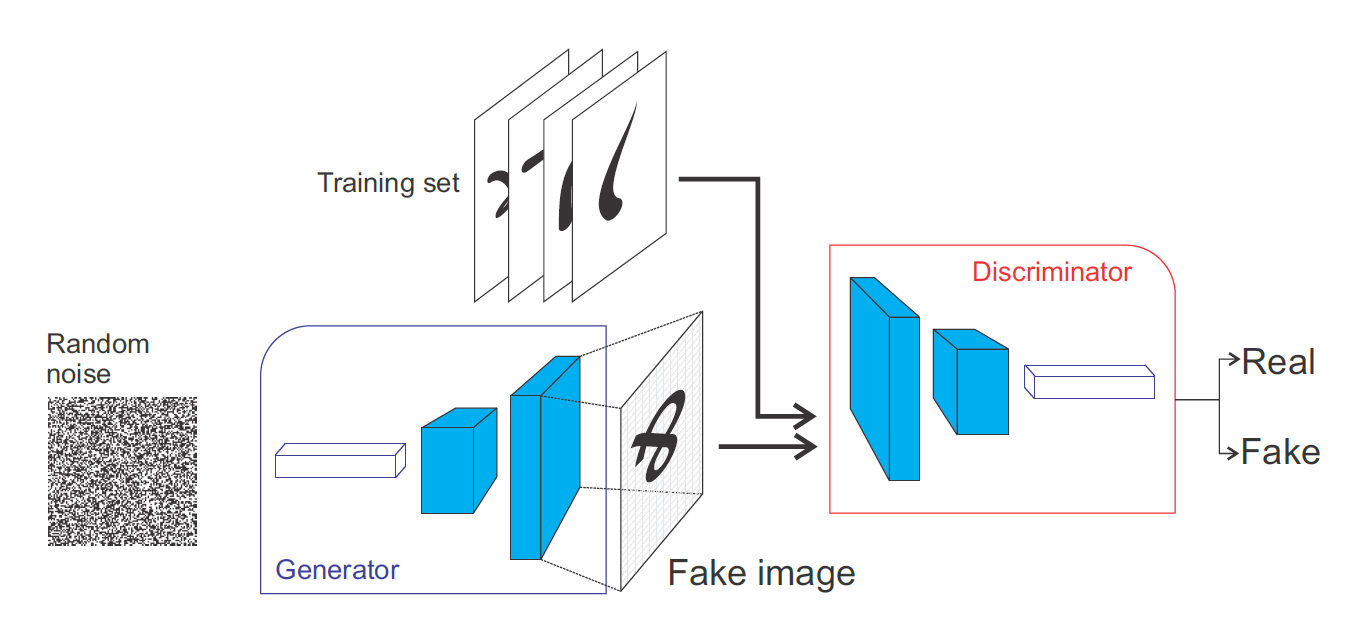

In [ ]:
def define_discriminator():
    model = Sequential()
    model.add(Input(shape=(5000,12)))
    model.add(Conv1D(filters=32, kernel_size=16, strides=1, padding='same'))
    model.add(LeakyReLU())
    model.add(Conv1D(filters=64, kernel_size=16, strides=1, padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=16, strides=1, padding='same'))
    model.add(LeakyReLU())
    model.add(Conv1D(filters=256, kernel_size=16, strides=1, padding='same'))
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def define_generator(latent_dim):#  latent_dim? understant
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    model.add(Input(shape=(latent_dim,)))
    model.add(Dense(5000, kernel_initializer=init, input_dim=latent_dim))
    model.add(Reshape((5000,1)))
    model.add(Bidirectional(LSTM(24, return_sequences=True,activation='tanh'), merge_mode='sum'))
    model.add(Dropout(0.5, noise_shape=None, seed=None))
    model.add(Dense(12, activation='tanh'))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
 
# generate n real samples with class labels
def generate_real_samples(ecgsignal,n):
    # generate inputs in [-0.5, 0.5]
    X = ecgsignal[np.random.choice(ecgsignal.shape[0],n)]
    # generate class labels
    y = ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
"""A latent space, also known as a latent feature space or embedding space, is an 
embedding of a set of items within a manifold in which items which resemble each
other more closely are positioned closer to one another in the latent space."""
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_in = randn(latent_dim*n).reshape(n,latent_dim)
    # reshape into a batch of inputs for the network
    return x_in
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(latent_dim,generator,n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim,n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, ecgsignal, n=1):
    # prepare real samples
    x_real, y_real = generate_real_samples(ecgsignal,n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(latent_dim, generator,n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    plt.plot(x_fake.reshape(12,5000)[1], color="red")
    plt.plot(x_real.reshape(12,5000)[1], color="green")
    plt.savefig("model_after{}epocs.png".format(epoch))
    plt.show()
 

def train(g_model, d_model, gan_model, ecg_sig, latent_dim,n_epochs=100, n_batch=128, n_eval=10):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(ecg_sig,half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(latent_dim,g_model,half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim,n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1)) # to forze the generative model to resemble the true ecgs and by so, learn
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim, ecg_sig)
  return 

We can think to apply it to augment the Poincare images, so the data.